In [2]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import shutil
import numpy as np

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

import grimoire as spell #Library of common analysis methods

import tcri

In [3]:
adata = sc.read("/Users/ceglian/Data/tcri/zhang/zhang_annotated.h5ad")

In [4]:
df = pd.read_csv("/Users/ceglian/Downloads/GSE179994_all.scTCR.tsv",sep="\t")
mapper1 = dict(zip(df["CellName"],df["CDR3(Beta1)"]))
mapper2 = dict(zip(df["CellName"],df["CDR3_nt(Beta1)"]))
ct = []
for x in adata.obs.index:
    if x in mapper2:
        ct.append(mapper2[x])  
adata.obs["trb"] = ct

In [132]:
df = pd.read_csv("/Users/ceglian/Downloads/GSE179994_all.scTCR.tsv",sep="\t")
mapper1 = dict(zip(df["CellName"],df["CDR3(Beta1)"]))
mapper2 = dict(zip(df["CellName"],df["CDR3_nt(Beta1)"]))
ct = []
for x in adata.obs.index:
    if x in mapper1:
        ct.append(mapper1[x])  
adata.obs["trbaa"] = ct

In [5]:
signed_mi          = True # Scale weights by corr ceoff
init_ortho         = True # Do an orthogonal initialization of weights
entropy_threshold  = 1.5 #Minimum Gene Entropy
mutual_information = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".","")) #Dict of Dict of MI
embedding_size     = 100  #Embedding Dimension
alpha              = 0.0 #Ortho Penalty
beta               = 0.0 #Ortho Penalty
c                  = 100
gain               = 10   #Initialized Weights Coefficient
vector_file        = "/Users/ceglian/Data/tcri/zhang_cd8_v2_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho) #Embedding File
retrain            = True #Retrain in Current Notebook
annotated_h5ad     = "/Users/ceglian/Data/tcri/zhang_annotated_tcri.h5ad" #Save analysis annotated h5ad
device             = "cpu" #Use cuda or cpu
figure_path        = "/Users/ceglian/Data/tcri/zhang/figures/" #Figure location

In [6]:
adata = adata[adata.obs["trb"]!=""]
adata = adata[adata.obs["trb"]!="nan"]
adata = adata[adata.obs["trb"]!="Other"]

adata = spell.pp.remove_meaningless_genes(adata, include_tcr=True)

tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata

100%|██████████| 18529/18529 [00:14<00:00, 1317.65it/s]


View of AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response', 'timepoint_relapse'
    var: 'entropy'

In [7]:
tcri.pp.register_clonotype_key(adata,"trb")

In [8]:
dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)

Running...
Loading Expression.
Indexing expression.


100%|██████████| 15252980/15252980 [00:07<00:00, 1993156.42it/s]


Finished.


In [10]:
if retrain:
    if os.path.exists(mutual_information):
        genes= pickle.load(open(mutual_information,"rb"))
        dataset.mi_scores = genes
        print("reloaded.")
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        c=c,
                        init_ortho=init_ortho,
                        device=device)
    pickle.dump(dict(dataset.mi_scores),open(mutual_information,"wb"))

reloaded.
*****************
Loading Dataset.
*****************



100%|██████████| 356/356 [00:00<00:00, 654.47it/s]


MI Loaded.
Loading Batches for Training.


100%|██████████| 356/356 [00:00<00:00, 5169.30it/s]


Ready to train.


**** Epoch 4800 	Loss: 33.66559
Training complete!
Loading average of 1st and 2nd weights.


100%|██████████| 356/356 [00:00<00:00, 1799002.68it/s]


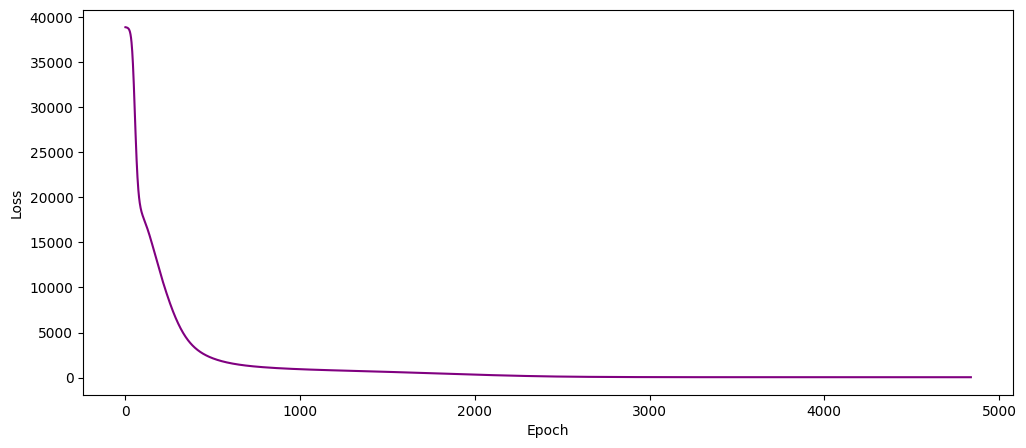

In [28]:
if retrain:
    cmps.train(100000,threshold=1e-5,alpha=alpha, beta=beta, update_interval=100)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [9]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)

Loading average of 1st and 2nd weights.


100%|██████████| 15252980/15252980 [00:24<00:00, 628055.69it/s]


Generating Cell Vectors.


100%|██████████| 77030/77030 [00:05<00:00, 13776.39it/s]

Found 0 Cells with No Counts.
Finished.


In [10]:
adata = cembed.get_adata()
adata

Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response', 'timepoint_relapse'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
# signatures = cembed.batch_correct("patient",reference="P1")
# corrected_adata =cembed.get_adata() #get a new adata with corrected vectors and umap
# adata= corrected_adata.copy()
# for p, v in signatures.items():
#     print(p, ",".join(embed.get_similar_genes(v).head(10)["Gene"]))

In [12]:
# import grimoire as grm
# grm.pp.run_harmony_workflow(adata,batch_key="patient")

In [13]:

ct = []
for x,y in zip(adata.obs["timepoint"],adata.obs["patient"]):
    if y == "P13" and x == "post.2":
        ct.append("post.3")
    else:
        ct.append(x)
adata.obs["timepoint"] = ct

ct = []
for x in adata.obs["timepoint"]:
    if "pre" in x:
        ct.append("Pre-treatment")
    else:
        ct.append("Post-treatment")
adata.obs["treatment"] = ct


ct = []
for x,y in zip(adata.obs["response"], adata.obs['timepoint']):
    ct.append("{}_{}".format(x,y))
adata.obs["timepoint_complex"] = ct


ct = []
for x,y,z in zip(adata.obs["response"], adata.obs['timepoint'], adata.obs["patient"]):
    ct.append("{}_{}_{}".format(x,y,z))
adata.obs["patient_timepoint_complex"] = ct

ct = []
for x,y in zip(adata.obs["patient"],adata.obs["response"]):
    if x in ["P13","P01", "P36","P37","P38","P1"]:
        ct.append("NR")
    elif y == "None":
        ct.append("Unknown")
    else:
        ct.append("CR")
adata.obs["complete_response"] = ct

ct = []
ctx = []
for x,y,z,w in zip(adata.obs["patient"],adata.obs["response"],  adata.obs["timepoint_complex"], adata.obs["complete_response"]):
    if x =="P13" and y == "None":
        ct.append("No")
        ctx.append("No_post.3")
    else:
        ct.append(y)
        ctx.append(z)

adata.obs["response"] = ct
adata.obs["timepoint_complex"] = ctx

ct = []
for x,y,z,w in zip(adata.obs["patient"],adata.obs["timepoint_complex"], adata.obs["complete_response"],adata.obs["treatment"]):
    if x =="P13" and y == "Yes_post.1":
        ct.append("Pre_Relapse")
    elif x == "P13" and y == "No_post.2":
        ct.append("Post_Relapse")
    elif x =="P1" and y == "Yes_post.2":
        ct.append("Pre_Relapse")
    elif x == "P1" and y == "No_post.3":
        ct.append("Post_Relapse")
    else:
        ct.append(z+"_"+w)
adata.obs["timepoint_relapse"] = ct

ct = []
for x,y,z in zip(adata.obs["response"], adata.obs['timepoint'], adata.obs["patient"]):
    ct.append("{}_{}_{}".format(x,y,z))
adata.obs["patient_timepoint_complex"] = ct

ct=[]
for x,y in zip(adata.obs["response"],adata.obs['complete_response']):
    if x == 'None':
        ct.append("None")
    else:
        ct.append(y)
adata.obs['cr'] = ct

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import tqdm
import scanpy as sc
import networkx as nx
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from scipy.spatial import distance
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
import numpy as np
import operator
import collections
import os   
import pandas as pd
import gc
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

markers = dict()
markers["Naive/CM"] = ["IL7R"]
markers["Activated"] = ["GZMB"]
markers["Memory"] = ["GZMK"]
markers["Dsyfunctional"] = ["CXCL13"]

def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from sklearn import preprocessing

def phenotype_probability(self, adata, phenotype_markers, return_distances=False, method="sparsemax", target_col="genevector", temperature=0.05, normalize=True):
    """
    Probablistically assign phenotypes based on a set of cell type labels and associated markers. 
    Can optionally return the original cosine distances and perform the assignment based on expression weight gene vectors.
    Loads into the anndata the pseudo-probabilities for each cell type and the deterministic label taken from the maximum probability over cell types.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param phenotype_markers: Dictionary of cell type labels (key) to gene markers used to define the cell type as a list (value).
    :type phenotype_markers: dict
    :param return_distances: Change the return type to a tuple that includes a dictionary containing the actual cosine distances alongside the phenotype probabilities.
    :type column: bool
    :param expression_weighted: Compute similarit to each cell using the expression weightedy marker gnene vector.
    :type column: bool
    :param target_col: Column label to load in deterministic cell asssignments in the obs data frame of the anndata object.
    :type target_col: bool
    :return: Anndata with cell type labels and probabilities, or optionally a tuple with the anndata and the raw cosine similarities.
    :rtype:  anndata.AnnData
    """
    if method == "softmax":
        print(bcolors.OKBLUE+"Using **SoftMax**"+bcolors.ENDC)
        pfunc = softmax
    elif method == "sparsemax":
        print(bcolors.OKBLUE+"Using **SparseMax**"+bcolors.ENDC)
        pfunc = self.entmax_15
    elif method == "normalized_exponential":
        print(bcolors.OKBLUE+"Using Normalized Exponential (Temp: {})".format(temperature)+bcolors.ENDC)
        pfunc = lambda x: self.normalized_exponential_vector(x, temperature)
    for x in adata.obs.columns:
        if "Pseudo-probability" in x:
            del adata.obs[x]
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    genes = adata.var.index.to_list()
    cells = adata.obs.index.to_list()
    all_markers = []
    for _, markers in phenotype_markers.items():
        all_markers += markers  
    all_markers = list(set(all_markers))
    probs = dict()

    for pheno, markers in phenotype_markers.items():
        print(bcolors.OKBLUE+"Computing similarities for {}".format(pheno)+bcolors.ENDC)
        print(bcolors.OKGREEN+"Markers: {}".format(", ".join(markers))+bcolors.ENDC)
        vector = self.embed.generate_vector(markers)
        probs[pheno] = cell_distance(self, vector,norm=normalize)
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = np.array(distribution)
    distribution = preprocessing.normalize(distribution)
    distribution = list(zip(*distribution))
    probabilities = []
    for d in distribution:
        p = pfunc(numpy.array(d))
        probabilities.append(p)
    
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    def load_predictions(adata,probs):
        prob_cols = []
        for ph in probs.keys():
            prob_cols.append(ph+" Pseudo-probability")
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        adata.uns["probability_columns"] = prob_cols
        return adata
    adata = load_predictions(adata, probs)
    if return_distances:
        return adata, res
    else:
        return adata

adata, dist = phenotype_probability(cembed, adata, markers, method="normalized_exponential", temperature=0.0001, return_distances=True, normalize=True)

Using Normalized Exponential (Temp: 0.0001)
Computing similarities for Naive/CM
Markers: IL7R


100%|██████████| 77030/77030 [00:01<00:00, 73449.57it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 77030/77030 [00:01<00:00, 72344.34it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 77030/77030 [00:01<00:00, 73754.34it/s]


Computing similarities for Dsyfunctional
Markers: CXCL13


100%|██████████| 77030/77030 [00:01<00:00, 71691.81it/s]


In [15]:
tcri.pp.joint_distribution(adata)

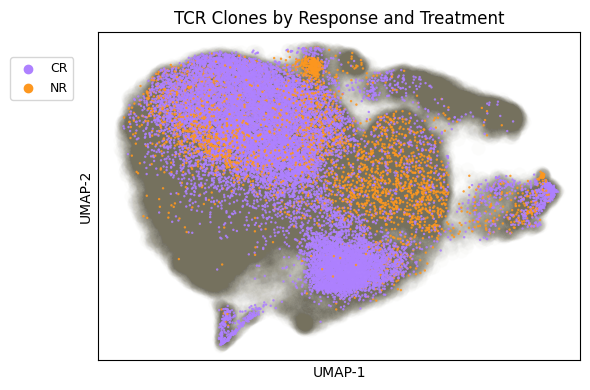

In [16]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.pl import tcri_colors

def top_clone_umap(adata, reduction="umap", top_n=10, fg_alpha=0.9, fg_size=25, bg_size=0.1, bg_alpha=0.6, figsize=(12,5), return_df=False,save=None):
    df = adata.obs
    seq_column = adata.uns["tcri_clone_key"]
    plt.figure(figsize = figsize)
    clonotype_counts = collections.defaultdict(int)
    response_dict = dict()
    for clonotype,r in zip(df[seq_column],df["complete_response"]):
        if r != "Unknown":
            clonotype_counts[clonotype] += 1
            response_dict[clonotype] = r
    top_clonotypes = sorted(clonotype_counts.items(), key=operator.itemgetter(1),reverse=True)
    top_clonotypes = [x[0] for x in top_clonotypes[:top_n]]
    ax1 = plt.subplot(1,1,1)
    x = [x[0] for x in adata.obsm["X_{}".format(reduction)]]
    y = [x[1] for x in adata.obsm["X_{}".format(reduction)]]
    sns.scatterplot(x=x,y=y, color="#75715E",  alpha=bg_alpha, ax=ax1, s=bg_size, linewidth=0.0)
    xonly = []
    yonly = []
    clonotype_labels = []
    size = []
    for clonotype,x1,y1 in zip(df[seq_column],x,y):
        clonotype = str(clonotype)
        if clonotype not in top_clonotypes or clonotype == "None" or clonotype == "nan":
            continue
        else:
            xonly.append(x1)
            yonly.append(y1)
            size.append(1/clonotype_counts[clonotype])
            clonotype_labels.append(response_dict[clonotype])         #str(clonotype) + " {}".format(clonotype_counts[clonotype]))
    dftop = pd.DataFrame.from_dict({"TCR Sequence":clonotype_labels,"Cells":size, "UMAP1":xonly,"UMAP2":yonly})
    colors = tcri_colors[2:] + tcri_colors + tcri_colors
    order = []
    for c in set(clonotype_labels):
        if c != "_Other":
            order.append(c)
    colors = colors[:len(set(clonotype_labels))]
    sns.scatterplot(data=dftop, x="UMAP1", y="UMAP2", hue="TCR Sequence", hue_order=order, ax=ax1, alpha=fg_alpha,s=fg_size, linewidth=0.0,palette=colors)
    ax1.set_xlabel('UMAP-1')
    ax1.set_ylabel('UMAP-2')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    ax1.set_title("TCR Clones by Response and Treatment")
    h,l = ax1.get_legend_handles_labels()
    ax1.legend(h[:top_n-1], l[:top_n-1], borderaxespad=2.,fontsize='9',bbox_to_anchor=(0, 1), loc='best')
    plt.tight_layout()
    if return_df:
        return dftop
    elif save != None:
        plt.savefig(save)
top_clone_umap(adata, top_n=1000, fg_size=3, figsize=(6,4),bg_size=100, bg_alpha=0.02, save="/Users/ceglian/zhang_clones.pdf")

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [18]:
ct = []
ctx = []
for x in adata.obs['timepoint_relapse']:
    if "CR" in x:
        ct.append("Responding")
        if "Post" in x:
            ctx.append("Post")
        else:
            ctx.append("Pre")
    elif "NR" in x:
        ct.append("Non-Responding")
        if "Post" in x:
            ctx.append("Post")
        else:
            ctx.append("Pre")
    elif "Relapse" in x:
        ct.append("Relapse")
        if "Post" in x:
            ctx.append("Post")
        else:
            ctx.append("Pre")
    else:
        ct.append("Unknown")
        ctx.append("Pre")
adata.obs['instant_response'] = ct
adata.obs['timepoint_instant'] = ctx 

i = 0
main_color_map = dict()
adata = adata.copy()
colors = tcri.pl.tcri_colors.copy() + tcri.pl.tcri_colors.copy() + tcri.pl.tcri_colors.copy() + tcri.pl.tcri_colors.copy()
for x in ["genevector","complete_response","response","treatment","timepoint_relapse","timepoint","patient","instant_response","timepoint_instant"]:
    ct = []
    print(x)
    for i, val in enumerate(set(adata.obs[x].tolist())):
        c = colors.pop(i)
        ct.append(c)
        main_color_map[val] = c
    adata.uns["{}_colors".format(x)] = ct

genevector
complete_response
response
treatment
timepoint_relapse
timepoint
patient
instant_response
timepoint_instant


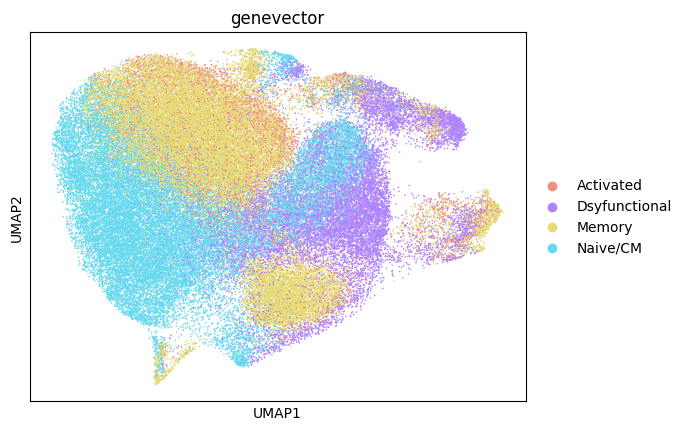

'/Users/ceglian/zhang.pdf'

In [19]:
import shutil
sc.pl.umap(adata,color="genevector",s=5,save="zhang.pdf")
shutil.copyfile("figures/umapzhang.pdf",os.path.join("/Users/ceglian/","zhang.pdf"))

<Axes: xlabel='genevector', ylabel='count'>

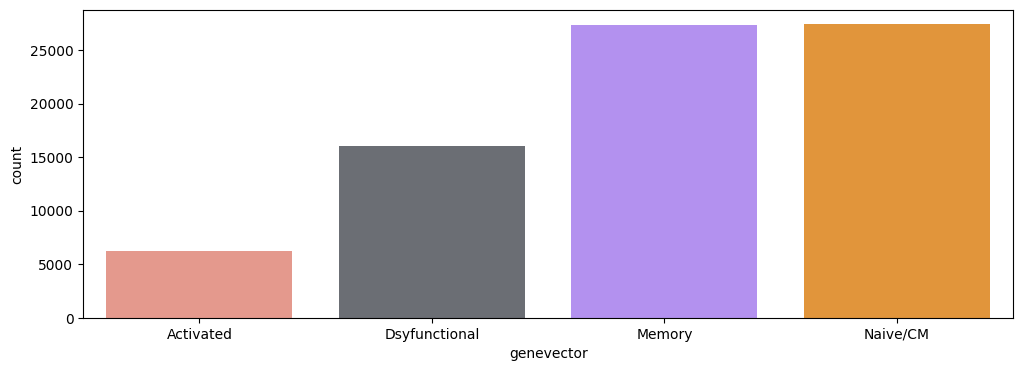

In [20]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="genevector",ax=ax)

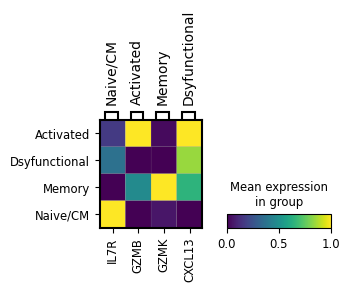

'/Users/ceglian/Data/tcri/zhang/figures/matrixplot_markers.pdf'

In [21]:
sc.pl.matrixplot(adata,markers,groupby="genevector", save="markers.pdf",standard_scale='var')
shutil.copyfile("figures/matrixplot_markers.pdf",os.path.join(figure_path, "matrixplot_markers.pdf"))

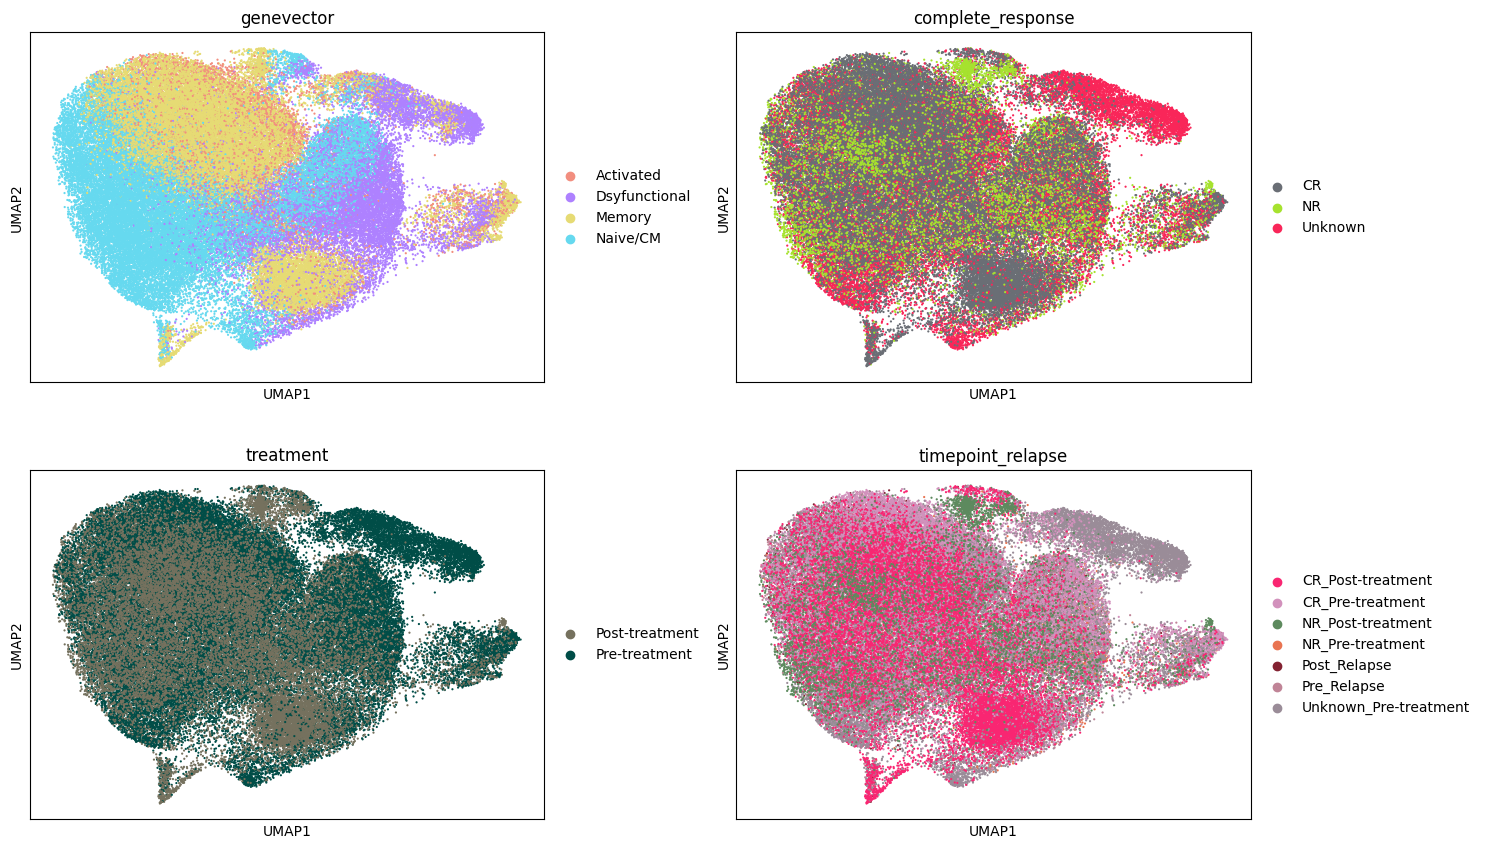

In [22]:
sc.pl.umap(adata,color=["genevector","complete_response","treatment", "timepoint_relapse"],s=10,wspace=0.25, ncols=2, save="main.pdf")
!cp figures/umapmain.pdf /Users/ceglian/Data/tcri/zhang/figures/

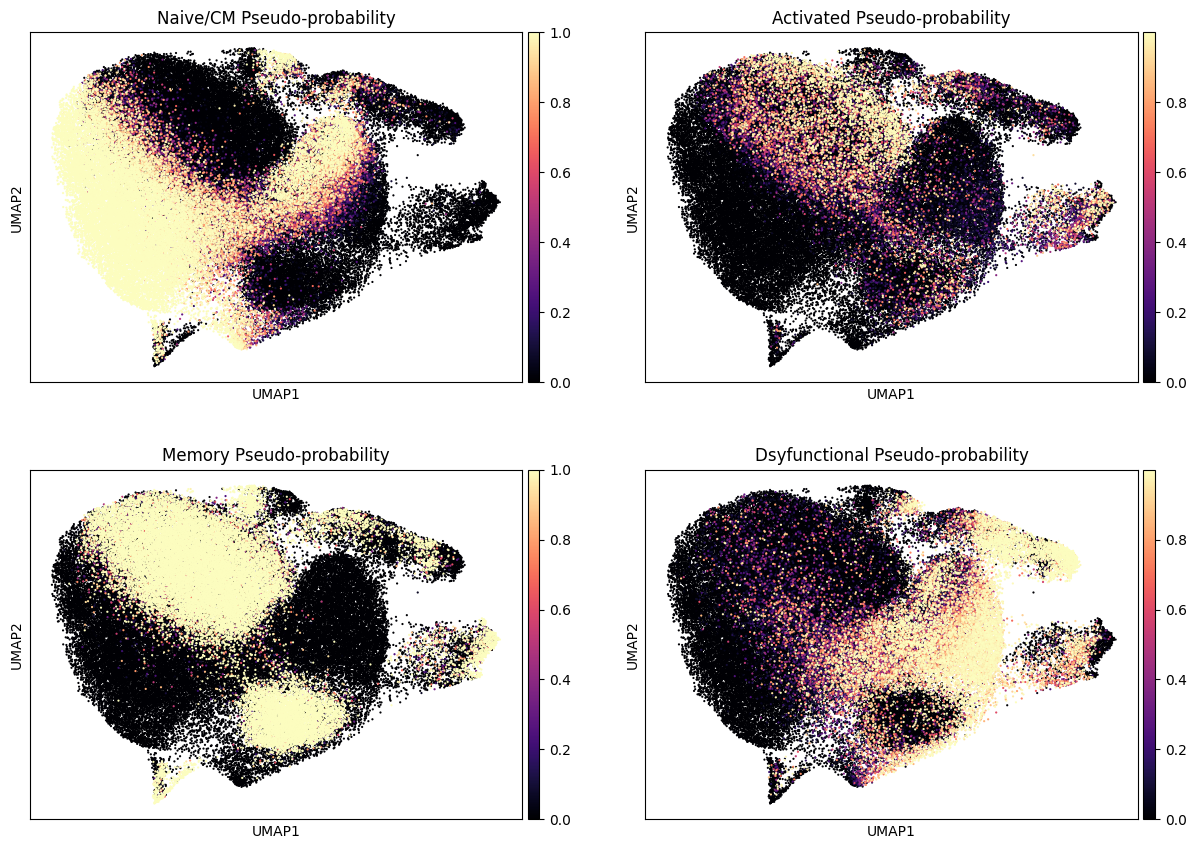

In [24]:
sc.pl.umap(adata,color=adata.uns["probability_columns"],ncols=2,s=10, save="probs.pdf", cmap="magma")
!cp figures/umapprobs.pdf /Users/ceglian/

In [25]:
tcri.pp.register_phenotype_key(adata,"genevector")
adata.uns["tcri_phenotype_key"]

'genevector'

In [26]:
tcri.pp.joint_distribution(adata)
adata.uns["joint_distribution"]

clonotype      TGCAAAAGAATACCGGACGAGCAGTACTTC  \
Naive/CM                                  0.0   
Activated                                 0.0   
Memory                                    1.0   
Dsyfunctional                             0.0   

clonotype      TGCAAGAACGTCGGCCCTAATGGCTACACCTTC  \
Naive/CM                                 0.99453   
Activated                                0.00005   
Memory                                   0.00000   
Dsyfunctional                            0.00542   

clonotype      TGCAAGGCCGGGACAGGGGGAAAGAGGAACACTGAAGCTTTCTTT  \
Naive/CM                                             0.80779   
Activated                                            0.02901   
Memory                                               0.08256   
Dsyfunctional                                        0.08063   

clonotype      TGCACAGCCTGGGACAGGGCCCTTACTGAAGCTTTCTTT  \
Naive/CM                                       0.95352   
Activated                                      0.00009   
Memory                                         0.00000   
Dsyfunctional                                  0.04639   

clonotype      TGCACATCAGGGTCCTACGAGCAGTACTTC  \
Naive/CM                              0.00000   
Activated                             0.00022   
Memory                                1.99978   
Dsyfunctional                         0.00000   

clonotype      TGCACCCTGGACAGGACGGGAGGCTACACCTTC  \
Naive/CM                                 0.99610   
Activated                                0.00001   
Memory                                   0.00000   
Dsyfunctional                            0.00389   

clonotype      TGCACCGCCCATGACAGTTTCACAGATACGCAGTATTTT  \
Naive/CM                                           0.0   
Activated                                          0.0   
Memory                                             0.0   
Dsyfunctional                                      1.0   

clonotype      TGCACCGGGGGTGGCCTCGAAAACATTCAGTACTTC  \
Naive/CM                                    0.99981   
Activated                                   0.00000   
Memory                                      0.00000   
Dsyfunctional                               0.00019   

clonotype      TGCACTACCTTGGGGACAGGGTTTTCCAACTATGGCTACACCTTC  \
Naive/CM                                             0.99987   
Activated                                            0.00000   
Memory                                               0.00000   
Dsyfunctional                                        0.00013   

clonotype      TGCAGACATGGGGGGCTGGAGACCCAGTACTTC  ...  \
Naive/CM                                 0.04879  ...   
Activated                                0.00755  ...   
Memory                                   0.00000  ...   
Dsyfunctional                            0.94366  ...   

clonotype      TGTGTCAGCTGGGGACAGGGTTACGAGCAGTACTTC  \
Naive/CM                                    0.99845   
Activated                                   0.00012   
Memory                                      0.00000   
Dsyfunctional                               0.00143   

clonotype      TGTGTCCGGGGTAGCACAGATACGCAGTATTTT  \
Naive/CM                                     1.0   
Activated                                    0.0   
Memory                                       0.0   
Dsyfunctional                                0.0   

clonotype      TGTGTCGCACGGAGCTCCTACAATGAGCAGTTCTTC  \
Naive/CM                                    0.00678   
Activated                                   0.00554   
Memory                                      0.98712   
Dsyfunctional                               0.00055   

clonotype      TGTGTGCCACCAGCAGAGACACAGGGTGGGAGAGGAGCTTTCTTT  \
Naive/CM                                             0.00000   
Activated                                            0.00204   
Memory                                               0.00000   
Dsyfunctional                                        0.99796   

clonotype      TGTGTGGCGGGTCTCGGTGAAAAACTGTTTTTT  \
Naive/CM      

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator
from tcri.pl import tcri_colors

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.utils import Phenotypes, CellRepertoire, Tcell, plot_pheno_sankey, plot_pheno_ternary_change_plots, draw_clone_bars, probabilities
from tcri.preprocessing import clone_size, joint_distribution
from tcri.metrics import clonotypic_entropies as centropies
from tcri.metrics  import phenotypic_entropies as pentropies
from tcri.metrics  import clonality as clonality_tl
from tcri.metrics  import flux as flux_tl
from tcri.metrics  import probability_distribution as pdistribution
from tcri.metrics  import mutual_information as mutual_information_tl
from tcri.metrics  import phenotypic_entropy_delta as phenotypic_entropy_delta_tl
from tcri.metrics  import clone_fraction as clone_fraction_tl


def tcri_boxplot(adata, function, groupby=None,ylabel="", splitby=None,figsize=(8,4),s=20,order=None, hue_order=None, palette=None, add_stats=True):
    if palette == None:
        palette = tcri_colors
    if groupby == None and splitby == None:
        data = function(adata)
        df = pd.DataFrame(list(data.items()), columns=['Phenotype', 'Clonotypic Entropy'])
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        fig,ax=plt.subplots(1,1,figsize=figsize)
        sns.stripplot(data=df,x="Phenotype",y=ylabel,s=s,ax=ax, palette=palette)
        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        fig.tight_layout()
    elif groupby != None and splitby == None:
        groups = adata.obs[groupby].unique()
        dfs = []
        for group in groups:
            data = function(adata[adata.obs[groupby]==group])
            df = pd.DataFrame(list(data.items()), columns=['Phenotype',ylabel])
            df[groupby] = group
            dfs.append(df)
        df = pd.concat(dfs)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        if order == None:
            order = df.groupby(["Phenotype"]).median(ylabel).sort_values(ylabel).index.tolist()
        fig,ax=plt.subplots(1,1,figsize=figsize)
        sns.stripplot(data=df,x="Phenotype",y=ylabel,s=s,hue=groupby,ax=ax,order=order, palette=palette)
        sns.boxplot(data=df,x="Phenotype",y=ylabel,ax=ax, color="#999999",order=order)

        annotator = Annotator(ax, pairs=[("Thur", "Fri"), ("Fri", "Sat"), ("Sat", "Sun")], data=df, x="day", y="total_bill")
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()


        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_title(ylabel)
        ax.set_ylabel(ylabel)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        fig.tight_layout()
    elif groupby != None and splitby != None:
        groups = adata.obs[groupby].unique()
        dfs = []
        for group in groups:
            sub = adata[adata.obs[groupby]==group]
            splits = sub.obs[splitby].unique()
            for split in splits:
                data = function(sub[sub.obs[splitby]==split])
                df = pd.DataFrame(list(data.items()), columns=['Phenotype', ylabel])
                df[groupby] = group
                df[splitby] = split
                dfs.append(df)
        df = pd.concat(dfs)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        fig,ax=plt.subplots(1,1,figsize=figsize)
        if order == None:
            order = df.groupby(["Phenotype"]).median(ylabel).sort_values(ylabel).index.tolist()
        if hue_order == None:
            hue_order = list(sorted(set(df[splitby])))
        print(order)
        if add_stats:
            pairs = []
            hpairs = list(itertools.combinations(hue_order, 2))
            for x in order:
                print(x)
                for z,w in hpairs:
                    pairs.append(((x,z),(x,w)))
                print(pairs)
        print(pairs)
        sns.boxplot(data=df,
                    x="Phenotype",
                    y=ylabel,
                    ax=ax, 
                    hue=splitby,
                    order=order,
                    hue_order=hue_order,
                    palette=palette)
        annotator = Annotator(ax, pairs=pairs, data=df, x="Phenotype", y=ylabel, hue=splitby,order=order, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_title(ylabel)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        ax.set_ylabel(ylabel)
        fig.tight_layout()
    else:
        raise ValueError("'groupby' must be set to use 'splitby'.")
    return ax

def clonality(adata, groupby = None, splitby=None, s=10, order=None, figsize=(12,5), palette=None):
    return tcri_boxplot(adata,clonality_tl, ylabel="Clonality", groupby=groupby, splitby=splitby, s=s, figsize=figsize, order=order, palette=palette)

def clonotypic_entropy(adata, method="probabilistic", normalized=True, groupby=None, splitby=None, s=10, figsize=(12,5), order=None, palette=None):
    func = lambda x : centropies(x, normalized=normalized, method=method)
    return tcri_boxplot(adata, func, groupby=groupby, ylabel="Clonotypic Entropy", splitby=splitby, s=s, figsize=figsize, order=order, palette=palette)

In [30]:
ct = []
for x in adata.obs["timepoint_complex"]:
    if "pre" in x:
        ct.append("Pre-Treatment")
    else:
        ct.append(x)
adata.obs["tc"] = ct

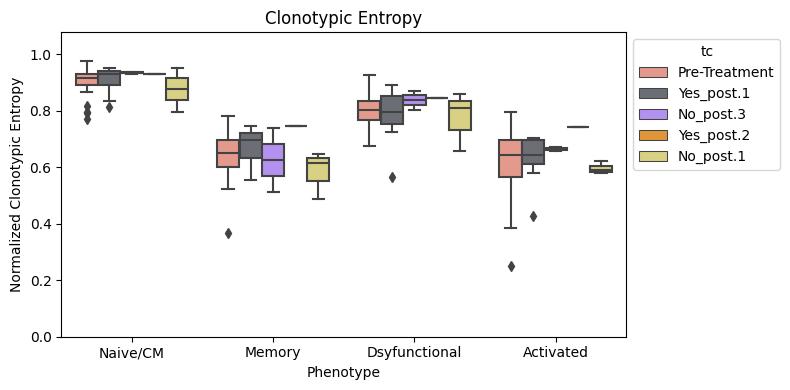

In [40]:
response = "detailed"
tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(8,4),method="probabilistic",splitby="tc",normalized=True,order=["Naive/CM","Memory","Dsyfunctional","Activated"])
plt.title("Clonotypic Entropy")
plt.ylabel("Normalized Clonotypic Entropy")
plt.savefig(os.path.join("/Users/ceglian", "zhang_cent_{}.pdf".format(response)))

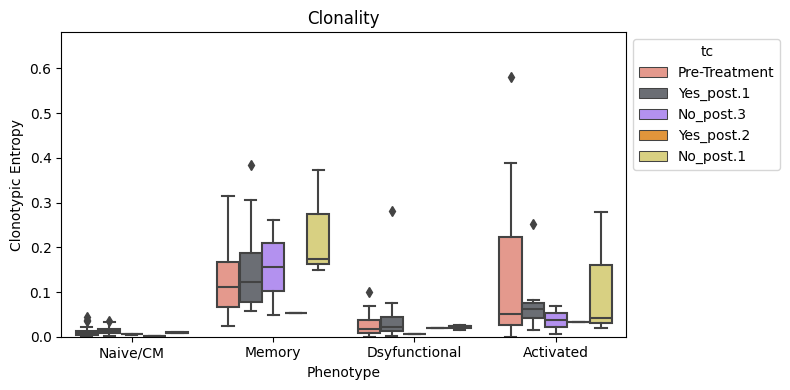

In [39]:
response = "detailed"
tcri.pl.clonality(adata,groupby="patient",figsize=(8,4),splitby="tc",order=["Naive/CM","Memory","Dsyfunctional","Activated"])
plt.title("Clonality")
plt.ylabel("Clonotypic Entropy")
plt.savefig(os.path.join("/Users/ceglian", "zhang_clonality_{}.pdf".format(response)))

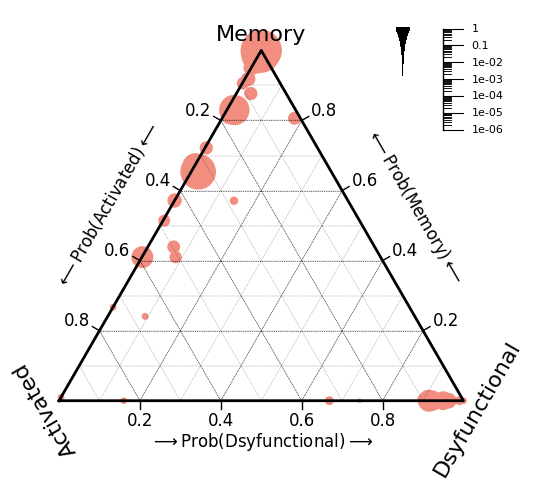

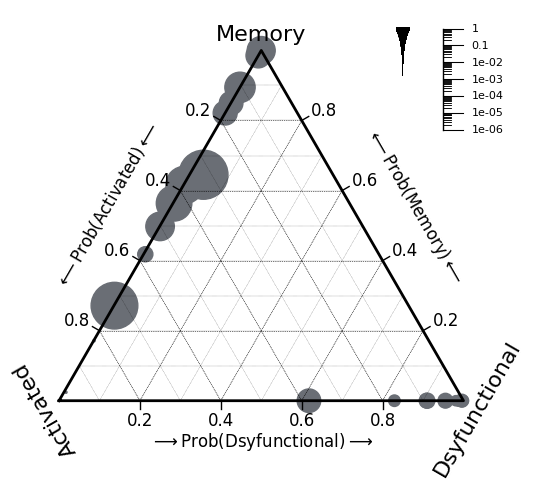

In [161]:
#response = "On-treatment"
tcri.pp.clone_size(adata)

scale_fxn = lambda x: 100*(x**(1/2))

# response="On-treatment"
#sub = adata[adata.obs["complete_response"] == "NR"]
sub = adata[adata.obs["clone_size"] > 10]
#sub = sub[sub.obs['complete_response']=="NR"]
tcri.pp.joint_distribution(sub)
path = os.path.join(figure_path, "relapse_pre_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["Pre_Relapse"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[0],save=path)
path = os.path.join(figure_path, "relapse_post_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["Post_Relapse"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[1],save=path)

scale_fxn = lambda x: 20*(x**(1/2))
path = os.path.join(figure_path, "relapse_transition_ternary.pdf")


# tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["Pre_Relapse","Post_Relapse"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[2],save=path)


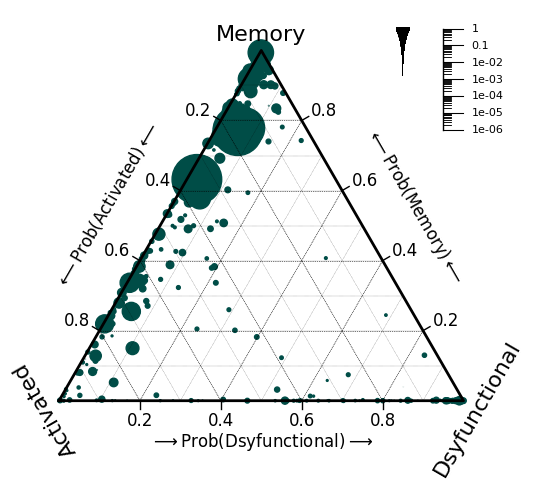

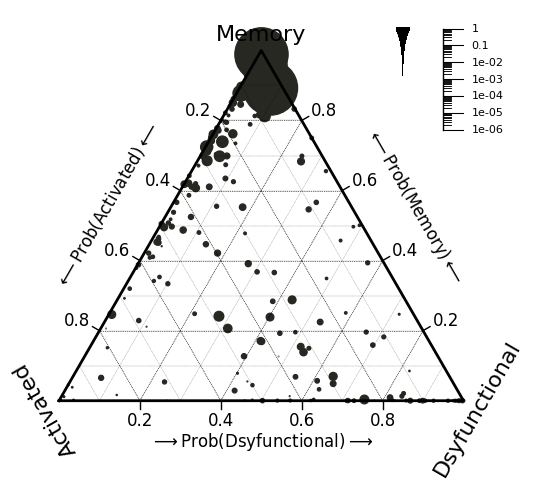

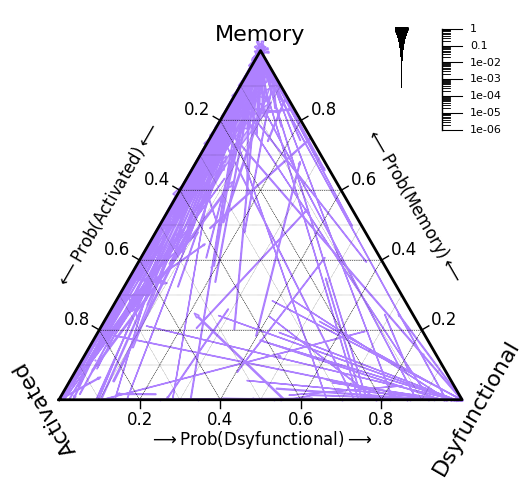

In [178]:
#response = "On-treatment"
figure_path = "/Users/ceglian/"
scale_fxn = lambda x: 120*(x**(1/2))
#main_color_map["CR_Pre-treatment"] = ""
# response="On-treatment"
#sub = adata[adata.obs["complete_response"] == "NR"]
sub = adata[adata.obs["clone_size"] > 5]
#sub = sub[sub.obs['complete_response']=="NR"]
tcri.pp.joint_distribution(sub)
path = os.path.join(figure_path, "cr_pre_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["CR_Pre-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[12],save=path)
path = os.path.join(figure_path, "cr_post_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["CR_Post-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[13],save=path)

scale_fxn = lambda x: 20*(x**(1/2))
path = os.path.join(figure_path, "cr_transition_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["CR_Pre-treatment","CR_Post-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[2],save=path)
# tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="timepoint",conditions=["post.1"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[0])

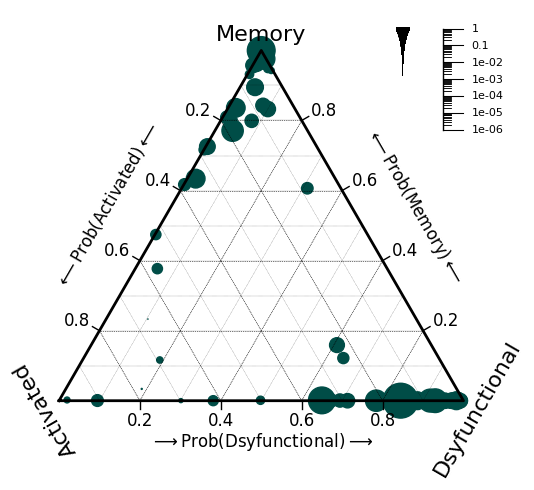

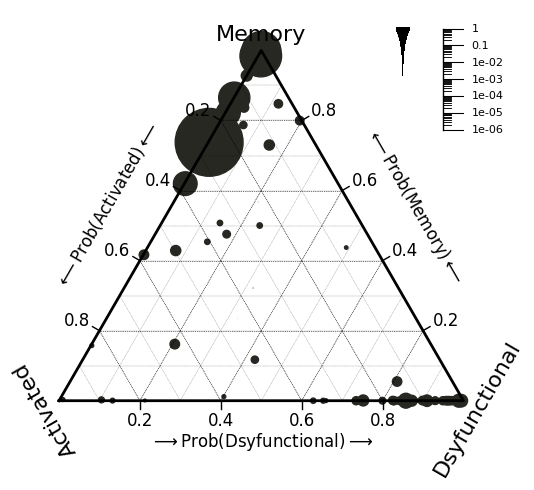

In [179]:
#response = "On-treatment"

scale_fxn = lambda x: 120*(x**(1/2))

# response="On-treatment"
#sub = adata[adata.obs["complete_response"] == "NR"]
sub = adata[adata.obs["clone_size"] > 5]
#sub = sub[sub.obs['complete_response']=="NR"]
tcri.pp.joint_distribution(sub)
path = os.path.join(figure_path, "nr_pre_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["NR_Pre-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[12],save=path)
path = os.path.join(figure_path, "nr_post_ternary.pdf")
tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["NR_Post-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[13],save=path)

# scale_fxn = lambda x: 20*(x**(1/2))
# path = os.path.join(figure_path, "nr_transition_ternary.pdf")
# tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dsyfunctional"],splitby="timepoint_relapse",conditions=["NR_Pre-treatment","CR_Post-treatment"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[2],save=path)
# tcri.pl.probability_ternary(sub,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="timepoint",conditions=["post.1"],scale_function=scale_fxn,color=tcri.pl.tcri_colors[0])

In [128]:
set(adata.obs['timepoint_relapse'])
s=adata[adata.obs["timepoint_relapse"].isin(["NR_Pre-treatment","NR_Post-treatment"])]
print(set(s.obs["patient"]))

{'P37', 'P36', 'P13', 'P38', 'P1'}


View of AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response', 'timepoint_relapse', 'cr', 'genevector', 'instant_response', 'timepoint_instant', 'tc', 'clone_size', 'trbaa', 'pent', 'pentv', 'tcs', 'Naive/CM Pseudo-probability', 'Activated Pseudo-probability', 'Memory Pseudo-probability', 'Dsyfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'probability_columns', 'joint_distribution', 'log1p', 'genevector_colors', 'complete_response_colors', 'response_colors', 'treatment_colors', 'timepoint_relapse_colors', 'timepoint_colors', 'patient_colors', 'instant_response_colors', 'timepoint_instant_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'tc_colors', 'timepoint_complex_colors'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'di

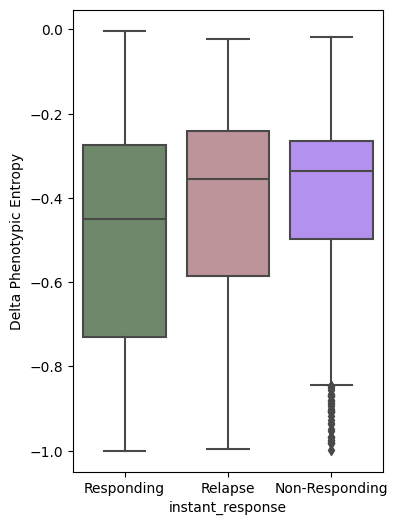

In [215]:
sub = adata[adata.obs["clone_size"] >0]
print(sub)
tcri.pl.phenotypic_entropy_delta(sub,
                                 groupby="instant_response",
                                 key='timepoint_instant',
                                 from_this="Pre", 
                                 to_that="Post", 
                                 figsize=(4,6),
                                 palette=main_color_map,
                                 save="/Users/ceglian/Data/tcri/zhang/figures/zhang_phenotypic_entropy_delta.pdf")

hit


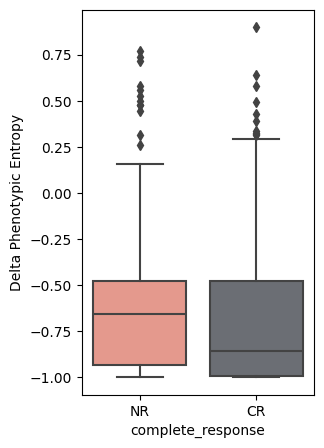

In [39]:
tcri.pp.clone_size(adata)
sdata = adata[adata.obs["clone_size"] > 1]
tcri.pp.joint_distribution(sdata)
tcri.pl.phenotypic_entropy_delta(sdata,groupby="complete_response",key="treatment",from_this="Pre-treatment",to_that="Post-treatment",figsize=(3,5))

annotator = Annotator(ax, pairs=pairs, data=df, x="Phenotype", y=ylabel, hue=splitby,order=order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()

plt.savefig("/Users/ceglian/flux.pdf")

In [220]:
for x in set(adata.obs['patient']):
    sub = adata[adata.obs["patient"] == x]
    for tp in set(sub.obs["timepoint"]):
        subsub = sub[sub.obs['timepoint'] == tp]
        print(x, tp,set(subsub.obs["response"]), set(subsub.obs['complete_response']),set(subsub.obs['treatment']))


P26 pre {'None'} {'Unknown'} {'Pre-treatment'}
P2 pre {'None'} {'Unknown'} {'Pre-treatment'}
P36 post.1 {'No'} {'NR'} {'Post-treatment'}
P35 pre {'Yes'} {'CR'} {'Pre-treatment'}
P35 post.1 {'Yes'} {'CR'} {'Post-treatment'}
P17 pre {'None'} {'Unknown'} {'Pre-treatment'}
P38 post.1 {'No'} {'NR'} {'Post-treatment'}
P3 pre {'None'} {'Unknown'} {'Pre-treatment'}
P37 post.1 {'No'} {'NR'} {'Post-treatment'}
P20 pre {'None'} {'Unknown'} {'Pre-treatment'}
P14 pre {'None'} {'Unknown'} {'Pre-treatment'}
P16 pre {'None'} {'Unknown'} {'Pre-treatment'}
P25 pre {'None'} {'Unknown'} {'Pre-treatment'}
P22 pre {'None'} {'Unknown'} {'Pre-treatment'}
P12 pre {'None'} {'Unknown'} {'Pre-treatment'}
P30 pre {'Yes'} {'CR'} {'Pre-treatment'}
P30 post.1 {'Yes'} {'CR'} {'Post-treatment'}
P8 pre {'None'} {'Unknown'} {'Pre-treatment'}
P24 pre {'None'} {'Unknown'} {'Pre-treatment'}
P7 pre {'None'} {'Unknown'} {'Pre-treatment'}
P1 pre {'Yes'} {'NR'} {'Pre-treatment'}
P1 post.1 {'Yes'} {'NR'} {'Post-treatment'}
P1 po

In [221]:
import pandas as pd
neotcr = pd.read_csv("/Users/ceglian/Downloads/neotcrdb.csv")

In [ ]:
tcri.pl.clonality(adata)

In [135]:
neotcr = neotcr[neotcr["Tumor"].isin(['Non-small cell lung cancer','Lung cancer','Head and neck squamous cell carcinoma'])]

In [222]:
neotcr["TRB_CDR3"].tolist()

['CASSLVSPSEQFF',
 'CASSLFTGTNEQFF',
 'CASSLDQGAQDNEQFF',
 'CASSQSGGGGFSYNEQFF',
 'CASSLGRASNQPQHF',
 'CASSVERENTGELFF',
 'CASSGRSGGEQFF',
 'CATSDSGPGEQYF',
 'CASSLVPRARGTEAFF',
 'CASSQERQTSYEQYF',
 'CASSPGSTSGRVRETQYF',
 'CASSGGATYNEQFF',
 'CASSLDQGLNTEAFF',
 'CASAGTSGWQETQYF',
 'CASSLAPQGEAFF',
 'CASSQERGLAGFNEQFF',
 'CASSQALAGPEQFF',
 'CASSFEADTQYF',
 'CATSLEADTQYF',
 'CASSLYGPLSSYNEQFF',
 'CASSLEATSVYNEQFF',
 'CASSIDGAGGPPGELFF',
 'CASSTQGLYGYTF',
 'CASTQGGGLAPHYEQYF',
 'CASSSRTSGRHNEQFF',
 'CATSDFRAAWYEQYF',
 'CATSREGQDTHLGEQYF',
 'CASSLTGETQYF',
 'CASSLAGQSSYEQYF',
 'CASSLGSAKATNEKLFF',
 'CASRGAPGRENTEAFF',
 'CASSLEAGSTDTQYF',
 'CSARKTGRYEQYF',
 'CSASRGETQYF',
 'CASSLGTSGLYNEQFF',
 'CAWSALAGARDTQYF',
 'CASSLGLPGTDTQYF',
 'CSAPPLAGDETQYF',
 'CATASDLQGDRSTEAFF',
 'CASGPFRDSVLTLVANVLTF',
 'CASRLPTTDEKLFF',
 'CASSVGQGSYEQYF',
 'CASSAGQGAYEQYF',
 'CSARDRSGTLGGELFF',
 'CASSEPRTSGISYNEQFF',
 'CASSSSSGGAFNEQFF',
 'CASQDSYEQYF',
 'CASSQDRPNYYGYTF',
 'CASSYWPTTGESTDTQYF',
 'CASSLAGTTVYNEQF

In [223]:
natcr = [str(x) for x in neotcr["TRB_CDR3"] if str(x) != "nan"]
natcr += vdjdb_nobadref_human.obs["IR_VDJ_1_junction_aa"].unique().tolist()
natcr = list(set(natcr))

In [224]:
ct = []
vall = []
tcri.pp.register_clonotype_key(adata,"trbaa")
look = tcri.tl.phenotypic_entropies(adata)
for x in adata.obs["trbaa"]:
    val = look[x] 
    if val > 0.01:
        ct.append("High")
        vall.append(val)
    else:
        ct.append("Low")
        vall.append(val)
adata.obs["pent"] = ct
adata.obs["pentv"] = vall

In [225]:
df=adata.obs[["trbaa","pent","pentv"]].drop_duplicates()

In [226]:
df=adata.obs[["trbaa","pent","pentv"]].drop_duplicates()
df["neo"] = df["trbaa"].isin(natcr)
df.reset_index(inplace=True)

In [227]:
df = df.reindex()[["trbaa","pent","neo","pentv"]].drop_duplicates()
df = df.drop_duplicates("trbaa")

In [228]:
df = df.reindex()
df

trbaa  pent    neo    pentv
0         CAIGQGASDTQYF  High  False  0.60151
1          CASSSDRVEAFF  High  False  0.72151
2       CASSTRDRSTDTQYF  High  False  0.78417
3      CASSLSSGRSQETQYF  High  False  0.71126
4          CSVGGGNYGYTF  High  False  0.73320
...                 ...   ...    ...      ...
40888   CASSPGQLRGTEAFF  High  False  0.74045
40889    CASRADRNTGELFF  High  False  0.42885
40890  CASSLVYTEPTGELFF  High  False  0.58935
40891    CASIRDRGIGSQYF  High  False  0.67945
40892     CASSLEPSTEAFF  High  False  0.67648

[40893 rows x 4 columns]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:8.314e-01 U_stat=1.468e+06


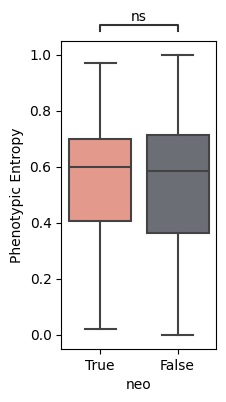

In [229]:
# dfx = df[df["pent"] == "High"]
fig,ax=plt.subplots(1,1,figsize=(2,4))
order = ["True",'False']
df["neo"] = [str(x) for x in df["neo"]]
sns.boxplot(data=df,x="neo",y="pentv",ax=ax,order=order)
# sns.swarmplot(data=df,x="neo",y="pentv",ax=ax)
pairs = [("False","True")]
annotator = Annotator(ax, pairs=pairs, data=df, x="neo", y="pentv", order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()

ax.set_ylabel("Phenotypic Entropy")
fig.savefig("/Users/ceglian/neo_comparison.pdf")

In [231]:
neotcr[neotcr["TRB_CDR3"].isin(df[df["pent"] == "High"]["trbaa"].tolist())].to_csv("/Users/ceglian/neo.csv")

In [232]:
neotcr[neotcr["TRB_CDR3"].isin(df[df["pent"] == "High"]["trbaa"].tolist())].to_csv("/Users/ceglian/Supplemental_table_1.csv")

In [1]:
#pd.crosstab(df['pent'],df['neo'])
# df["neo"] = pd.Categorical(df["neo"])
# df["pent"] = pd.Categorical(df["pent"])
df[["pent","neo"]].value_counts()
t = [[27853,55],[12967,18]] #this was manually set from above
stats.fisher_exact(t)

In [591]:
df

trbaa  pent    neo
0         CAIGQGASDTQYF  High  False
1          CASSSDRVEAFF  High  False
2       CASSTRDRSTDTQYF  High  False
3      CASSLSSGRSQETQYF  High  False
4          CSVGGGNYGYTF  High  False
...                 ...   ...    ...
40888   CASSPGQLRGTEAFF  High  False
40889    CASRADRNTGELFF   Low  False
40890  CASSLVYTEPTGELFF  High  False
40891    CASIRDRGIGSQYF  High  False
40892     CASSLEPSTEAFF  High  False

[40893 rows x 3 columns]

In [541]:
tcri.pp.joint_distribution(adata)

<Axes: ylabel='Proportion'>

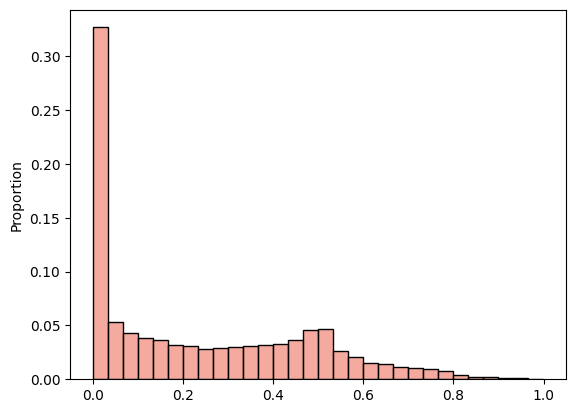

In [543]:
zdata = adata[adata.obs["clone_size"] < 5]
zdata = zdata[zdata.obs['genevector']!="Naive/CM"]
sns.histplot(list(tcri.tl.phenotypic_entropies(zdata).values()),bins=30,stat="proportion")

In [478]:
tcri.tl.phenotypic_entropies(zdata)

{'CAAAETSNQPQHF': 0.0,
 'CAAAGGGLGDTQYF': 0.02853,
 'CAAATANYGYTF': 0.00528,
 'CAACGGGYEPQHF': 0.0,
 'CAAEGFSNTEAFF': 0.23825,
 'CAAFSGSNGANVLTF': 0.11443,
 'CAAGDIGNTEAFF': 0.0,
 'CAAGEAYNEQFF': 9e-05,
 'CAAGGAGYGYTF': 0.32718,
 'CAAGGHNQPQHF': 0.48966,
 'CAAGGLAGSEQFF': 0.0637,
 'CAAGGPLYNEQFF': 0.32018,
 'CAAGPGGFSYEQYF': 0.10164,
 'CAAGPGPTHFDTGELFF': 0.61669,
 'CAAGQGGNEQFF': 0.53105,
 'CAAGRETQYF': 0.53535,
 'CAAGTGRREQYF': 0.09066,
 'CAAKGGNTEAFF': 0.0,
 'CAAKGTSGSLINEQFF': 0.0,
 'CAAKRSSGNTIYF': 0.52824,
 'CAALAWDKGNTEAFF': 0.75685,
 'CAANERGDQETQYF': 0.09423,
 'CAAPVGLAGEGSYEQYV': 0.36325,
 'CAARAELTEAFF': 0.58305,
 'CAARDRGTDTQYF': 0.28033,
 'CAARIGDTEAFF': 0.49644,
 'CAARPLDTEAFF': 0.0,
 'CAASGDRGNTGELFF': 0.22958,
 'CAASGQEDEQFF': 0.0037,
 'CAASPRGDLSYEQYF': 0.16769,
 'CAASQLGGEAFF': 0.0381,
 'CAATGWNTEAFF': 0.00067,
 'CAATSGRFEQYF': 0.16979,
 'CAATSGRYTGELFF': 0.64842,
 'CAATSRDTGELFF': 0.19838,
 'CAATVGVRNTEAFF': 0.47941,
 'CAAVARDSPLHF': 0.0052,
 'CAAVKRGGDYGYTF': 0.4781

([0, 1, 2], [Text(0, 0, 'CR'), Text(1, 0, 'Unknown'), Text(2, 0, 'NR')])

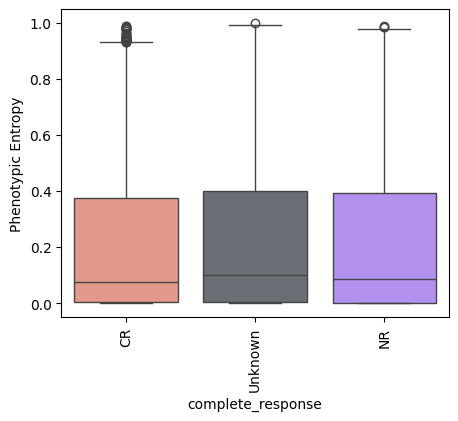

In [425]:
tcri.pl.phenotypic_entropy(adata,groupby="sample",splitby="complete_response")
plt.xticks(rotation=90)

pre {'Yes'}
post.1 {'Yes'}
post.2 {'Yes'}
post.3 {'No'}


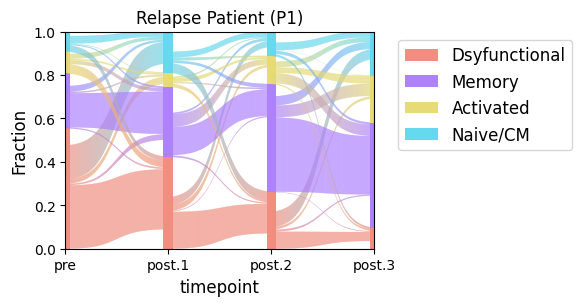

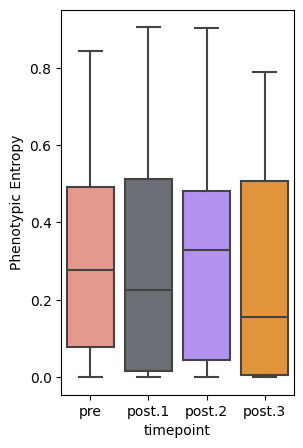

In [117]:
sub = adata[adata.obs["patient"] == "P1"]
sub = sub[sub.obs["clone_size"]>5]
for tp in set(sub.obs["timepoint"]):
    subsub = sub[sub.obs['timepoint'] == tp]
    print(tp,set(subsub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=True,phenotype_colors=main_color_map,figsize=(6,3))
plt.title("Relapse Patient (P1)")
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p1_sankey.pdf")
tcri.pl.phenotypic_entropy(sub,groupby="patient",splitby="timepoint",order=["pre","post.1","post.2","post.3"],figsize=(3,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p1_pent.pdf")

In [403]:
sub = adata[adata.obs["patient"] == "P13"]
sub = sub[sub.obs["clone_size"]>10]
for tp in set(sub.obs["timepoint"]):
    subsub = sub[sub.obs['timepoint'] == tp]
    print(tp,set(subsub.obs["response"]))

post.3 {'No'}
post.1 {'Yes'}
pre {'Yes'}


pre {'Yes'}
post.1 {'Yes'}
post.3 {'No'}


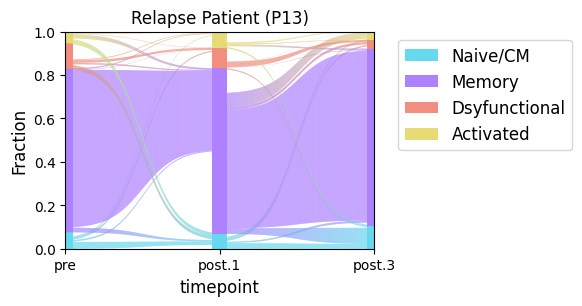

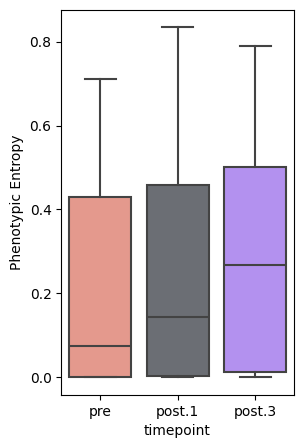

In [116]:
sub = adata[adata.obs["patient"] == "P13"]
sub = sub[sub.obs["clone_size"]>5]
for tp in set(sub.obs["timepoint"]):
    subsub = sub[sub.obs['timepoint'] == tp]
    print(tp,set(subsub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.3"],nt=False,normalize=True,phenotype_colors=main_color_map,figsize=(6,3))
plt.title("Relapse Patient (P13)")
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p13_sankey.pdf")
tcri.pl.phenotypic_entropy(sub,groupby="patient",splitby="timepoint",order=["pre","post.1","post.3"],figsize=(3,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p13_pent.pdf")

pre {'Yes'}
post.1 {'Yes'}


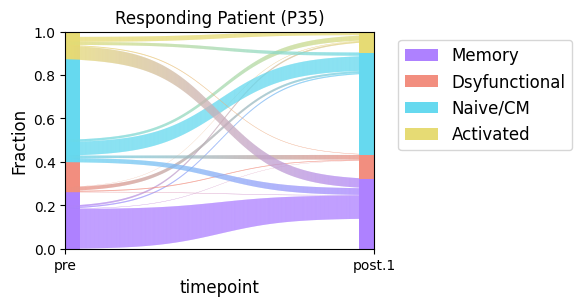

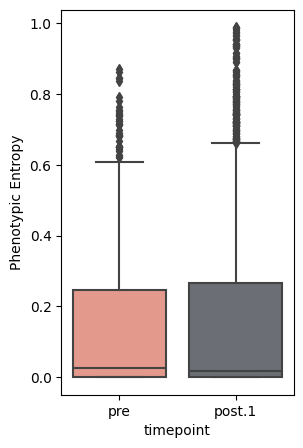

In [191]:
sub = adata[adata.obs["patient"] == "P35"]
sub = sub[sub.obs["clone_size"]>0]
for tp in set(sub.obs["timepoint"]):
    subsub = sub[sub.obs['timepoint'] == tp]
    print(tp,set(subsub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1"],nt=False,normalize=True,phenotype_colors=main_color_map,figsize=(6,3))
plt.title("Responding Patient (P35)")
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p35_sankey.pdf")
tcri.pl.phenotypic_entropy(sub,groupby="patient",splitby="timepoint",order=["pre","post.1"],figsize=(3,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p35_pent.pdf")

pre {'Yes'}
post.1 {'Yes'}


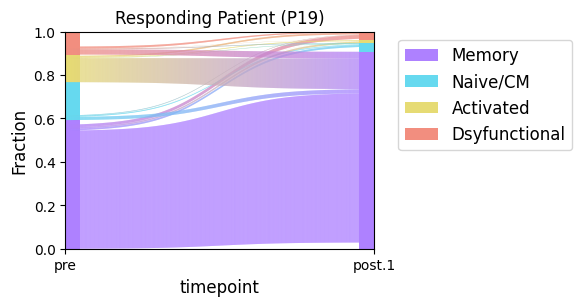

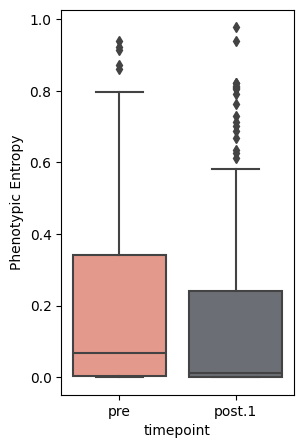

In [190]:
sub = adata[adata.obs["patient"] == "P19"]
sub = sub[sub.obs["clone_size"]>0]
for tp in set(sub.obs["timepoint"]):
    subsub = sub[sub.obs['timepoint'] == tp]
    print(tp,set(subsub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1"],nt=False,normalize=True,phenotype_colors=main_color_map,figsize=(6,3))
plt.title("Responding Patient (P19)")
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p19_sankey.pdf")
tcri.pl.phenotypic_entropy(sub,groupby="patient",splitby="timepoint",order=["pre","post.1"],figsize=(3,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p19_pent.pdf")

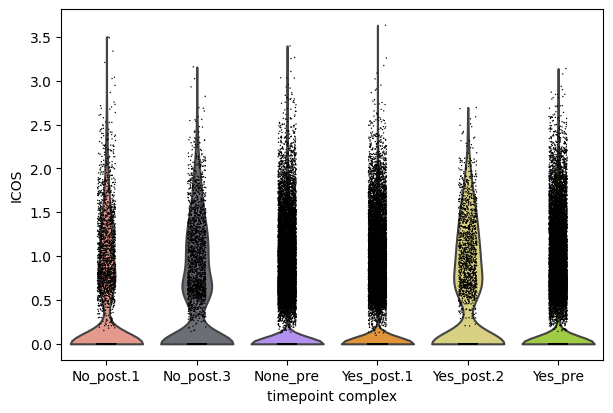

In [152]:
sc.pl.violin(adata,"ICOS",groupby='timepoint_complex')

Non-Responding #F28E7F
Relapse #6A6E75
Unknown #AE81FF
Responding #FD971F


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


['#FD971F', '#6A6E75', '#F28E7F', '#AE81FF']
                                                Clone        l1  \
0             TGTGCCAGCAGTCCCCTGGGAGTCTACGAGCAGTACTTC  0.345667   
1                      TGTGCCAGTGAGGGGTATGGCTACACCTTC  0.000123   
2       TGTGCCAGCAGCTTAGCGGTGGGACAGGGTTATGAGCAGTTCTTC  0.014693   
3          TGTGCCAGCAGCCTCAGCGGGAGCTCCTACGAGCAGTACTTC  0.339899   
4                TGTGCCTGGAAGGGACAATACTATGGCTACACCTTC  0.756005   
..                                                ...       ...   
9       TGTGCCAGCAGCACCAGGGACAGGAGCACAGATACGCAGTATTTT  0.264896   
10                  TGTGCCAGCATATTTGGGGGACGGGCTTTCTTT  0.006358   
11  TGTGCCATCAGTGAGACAGTAGGCGGGGGGGCCGTTGATACGCAGT...  0.767820   
12  TGTGCCAGCAGCCAAGACGTGGGGGACAGGGGATTTTCACCCCTCC...  0.178867   
13      TGCGCCAGCAGTCACAACAATCGACTAGCGGGAGAGCAGTTCTTC  0.000320   

   instant_response      Comparison  
0        Responding      Responding  
1        Responding      Responding  
2        Responding      Responding 

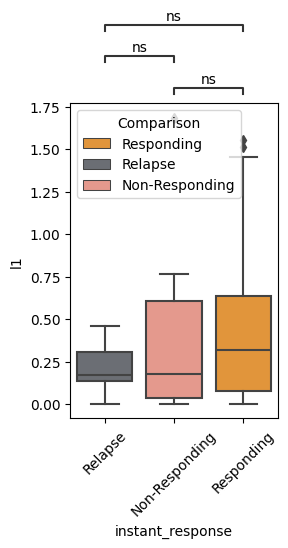

In [83]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import tqdm

from tcri.tl import flux as flux_tl
from tcri.pl import tcri_colors


def flux(adata, key, groupby, order, paint_dict=None, method="probabilistic", paint=None, distance_metric="l1", figsize=(12,5), palette=None):
    dfs = []
    if paint != None:
        palette = []
        legend_handles = [] 
        paint_categories = adata.obs[paint].unique()
        if paint_dict != None:
            pcolors = paint_dict
        else:
            pcolors = dict(zip(paint_categories, tcri_colors))
        for category in paint_categories:
            print(category,pcolors[category])
            handle = mpatches.Patch(color=pcolors[category], label=category)
            legend_handles.append(handle)
    else:
        if palette == None:
            if "{}_colors".format(paint) in adata.uns:
                palette = adata.uns["{}_colors".format(paint)]
            else:
                palette = tcri.pl.tcri_colors
    for x in tqdm.tqdm(list(set(adata.obs[groupby]))):
        sdata = adata[adata.obs[groupby]==x]
        hue_order = []
        for i in range(len(order)-1):
            l1_distances = flux_tl(sdata,key=key,from_this=order[i],to_that=order[i+1],distance_metric=distance_metric)
            df = pd.DataFrame(list(l1_distances.items()), columns=['Clone', distance_metric])
            df[groupby] = x
            if paint!=None:
                pcat = sdata.obs[paint].unique().tolist()[0]
                palette.append(pcolors[pcat])
            df["Comparison"] = pcat
            dfs.append(df)
    print(palette)
    df = pd.concat(dfs)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    order = df.groupby(groupby).median(distance_metric).sort_values(distance_metric).index.tolist()
    fig,ax=plt.subplots(1,1,figsize=figsize)
    sns.boxplot(data=df,x=groupby,y=distance_metric,hue="Comparison",palette=pcolors,ax=ax,dodge=False,order=order)
    pairs = list(itertools.combinations(set(df["Comparison"]),2))
    print(df)
    annotator = Annotator(ax, pairs=pairs, data=df, x=groupby, y=distance_metric,order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
    fig.tight_layout()
    return ax

# # smaller = adata.copy()
# # sc.pp.subsample(smaller, fraction=0.2)
# sdata = adata[adata.obs["clone_size"] > 1]
# flux(sdata, key="treatment", order=["pre","post"], groupby="response_disease", paint_dict=main_color_map, method="probabilistic", distance_metric="l1",paint="response",figsize=(7,5))
# plt.savefig("/Users/ceglian/flux_dkl.pdf")

sub = adata[adata.obs["clone_size"] > 20]
flux(sub, key="timepoint_instant", order=["Pre","Post"], groupby="instant_response", method="probabilistic", distance_metric="l1",paint="instant_response",figsize=(3,5),
            palette=main_color_map)
plt.xticks(rotation=45)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_flux_ir.pdf")

{'pre', 'post.1'}
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Yes_post vs. No_post: Mann-Whitney-Wilcoxon test two-sided, P_val:5.489e-01 U_stat=4.860e+02
Pre-Treatment vs. Yes_post: Mann-Whitney-Wilcoxon test two-sided, P_val:5.611e-04 U_stat=1.518e+04
Pre-Treatment vs. No_post: Mann-Whitney-Wilcoxon test two-sided, P_val:2.570e-01 U_stat=6.780e+02


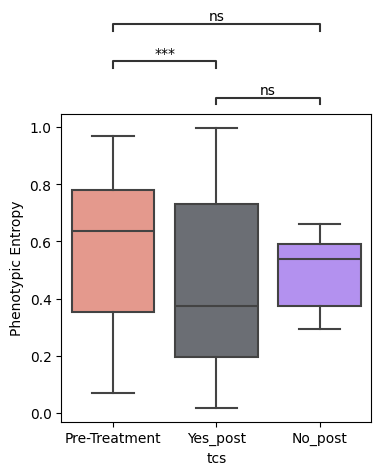

In [217]:
from tcri.tl import phenotypic_entropies as pentropies
from tcri.pl import tcri_colors
def phenotypic_entropy(adata, groupby, splitby, method="probabilistic", return_df=False, normalized=True, decimals=5, figsize=(5,4), save=None, order=None, rotation=0, minimum_clone_size=0, palette=None):
    ps = []
    rs = []
    r2 = []
    ts = []
    for r in set(adata.obs[groupby]):
        rdata = adata[adata.obs[groupby] == r]
        rdata = rdata[rdata.obs["clone_size"] >= minimum_clone_size]
        for p in set(rdata.obs[splitby]):
            pdata = rdata[rdata.obs[splitby] == p]
            for clone, ent in pentropies(pdata,method=method,normalized=normalized,decimals=decimals).items():
                rs.append(p)
                r2.append(ent)
                ts.append(clone)
                ps.append(r)
    df = pd.DataFrame.from_dict({groupby:ps,splitby:rs,"Phenotypic Entropy":r2,"Clone":ts})
    fig, ax = plt.subplots(1,1,figsize=figsize)
    if order == None:
        order = list(set(rs))
    if palette == None:
        palette = tcri_colors
    sns.boxplot(data=df, x=splitby,y="Phenotypic Entropy",ax=ax,order=order,palette=palette)
    pairs = list(itertools.combinations(set(df[splitby]),2))
    #print(pairs)
    annotator = Annotator(ax, pairs=pairs, data=df, x=splitby, y="Phenotypic Entropy",order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
    plt.xticks(rotation=rotation)
    if save!=None:
        fig.savefig(save)
    if return_df:
        return df
# xdata = adata[adata.obs["clone_size"] > 1]
# tcri.pp.joint_distribution(xdata)

# main_color_map["Yes_post"] = tcri_colors[2]
# main_color_map["No_post"] = tcri_colors[3]
# main_color_map["Yes_pre"] = tcri_colors[4]
# main_color_map["No_pre"] = tcri_colors[5]

set(adata.obs["timepoint_complex"])
sub = adata[adata.obs["timepoint_complex"].isin(["Yes_pre","No_post.1","Yes_post.1"])]

sub = sub[sub.obs["clone_size"] > 20]

tcri.pp.joint_distribution(sub)
sub.obs["timepoint"] = [x for x in sub.obs["timepoint"]]
print(set(sub.obs["timepoint"]))
df = phenotypic_entropy(sub,groupby="patient",splitby="tcs",order=["Pre-Treatment","Yes_post","No_post"], figsize=(4,4), save="/Users/ceglian/ent_smith.pdf")

# from scipy.stats import ttest_ind
# x = df[df["specificity"] == "Other"]["Phenotypic Entropy"].tolist()
# y = df[df["specificity"] != "Other"]["Phenotypic Entropy"].tolist()
# ttest_ind(x,y,equal_var=False)

NR #F28E7F
CR #6A6E75


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


['#6A6E75', '#F28E7F']
                                                Clone        l1  \
0             TGTGCCAGCAGTCCCCTGGGAGTCTACGAGCAGTACTTC  0.197263   
1                      TGTGCCAGTGAGGGGTATGGCTACACCTTC  0.069478   
2       TGTGCCAGCAGCTTAGCGGTGGGACAGGGTTATGAGCAGTTCTTC  0.070342   
3          TGTGCCAGCAGCCTCAGCGGGAGCTCCTACGAGCAGTACTTC  0.330749   
4                TGTGCCTGGAAGGGACAATACTATGGCTACACCTTC  0.616423   
..                                                ...       ...   
9       TGTGCCAGCAGCACCAGGGACAGGAGCACAGATACGCAGTATTTT  0.327594   
10                  TGTGCCAGCATATTTGGGGGACGGGCTTTCTTT  0.029608   
11  TGTGCCATCAGTGAGACAGTAGGCGGGGGGGCCGTTGATACGCAGT...  0.239796   
12  TGTGCCAGCAGCCAAGACGTGGGGGACAGGGGATTTTCACCCCTCC...  0.041223   
13      TGCGCCAGCAGTCACAACAATCGACTAGCGGGAGAGCAGTTCTTC  0.038803   

   complete_response Comparison  
0                 CR         CR  
1                 CR         CR  
2                 CR         CR  
3                 CR         CR  
4 

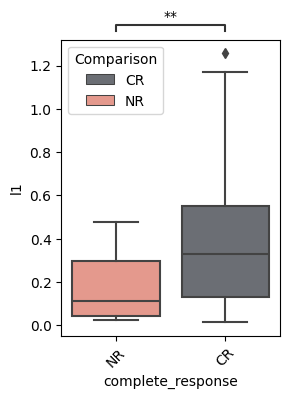

In [218]:

flux(sub, key="timepoint", order=["pre","post.1"], groupby="complete_response", method="probabilistic", distance_metric="l1",paint="complete_response",figsize=(3,4), palette=main_color_map)
plt.xticks(rotation=45)
plt.savefig("/Users/ceglian/zhang_flux_ir.pdf")

{'P13', 'P1'}
{'Post_Relapse', 'Pre_Relapse'}


100%|██████████| 2/2 [00:51<00:00, 25.98s/it]

['#F28E7F', '#F28E7F']


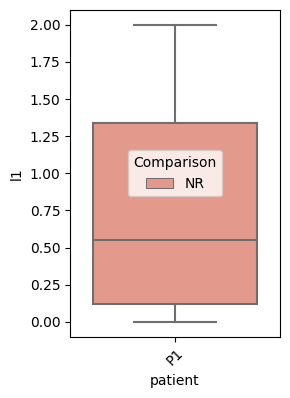

In [58]:
sub = adata[adata.obs["clone_size"] > 0]
sub = sub[sub.obs["timepoint_relapse"].isin(["Pre_Relapse","Post_Relapse"])]
print(set(sub.obs["patient"]))
print(set(sub.obs["timepoint_relapse"]))
tcri.pl.flux(sub, key="timepoint_relapse", order=["Pre_Relapse","Post_Relapse"], groupby="patient", method="probabilistic", distance_metric="l1",paint="timepoint",figsize=(3,4),
            palette=main_color_map)
plt.xticks(rotation=45)
plt.savefig("/Users/ceglian/zhang_flux.pdf")

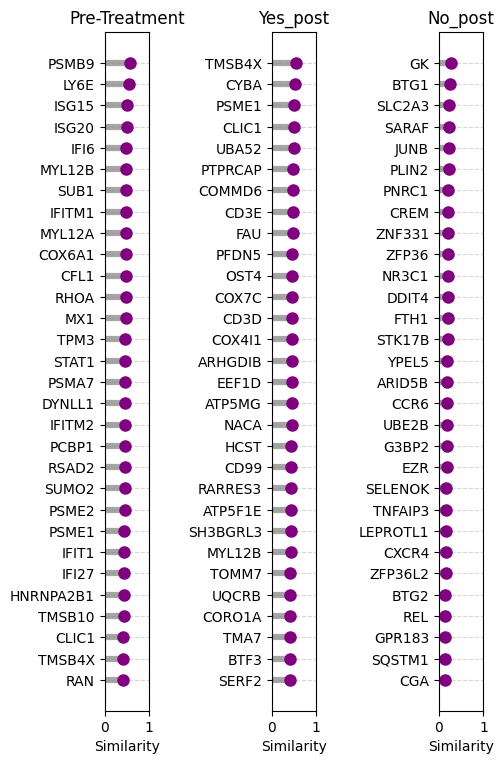

In [184]:
import numpy
import pandas as pd
def get_predictive_genes(self, adata, label, n_genes=10):
    """
    Compute the top n most similar genes to a given variable in the dataset.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param label: Label that defines the cateogies to find predictive genes.
    :type column: str
    :param n_genes: Number of most similar genes to return for each category.
    :type column: int
    :return: The most similar genes to each label stored in a dictionary.
    :rtype:  dict
    """
    vectors = dict()
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    comps = collections.defaultdict(list)
    for bc,x in zip(adata.obs.index,adata.obs[label]):
        comps[x].append(mapped_components[bc])
    mean_vecs = []
    for x, vec in comps.items():
        ovecs = []
        vec = numpy.average(vec,axis=0)
        for oph, ovec in comps.items():
            if oph != x:
                ovecs.append(numpy.average(ovec,axis=0))
        aovec = numpy.median(ovecs,axis=0)
        vector = numpy.subtract(vec,aovec)
        # vector = numpy.subtract(vector,self.dataset_vector)
        vectors[x] = vector
    markers = dict()
    for x, mvec in vectors.items():
        ct_sig = self.embed.get_similar_genes(mvec)[:n_genes]
        markers[x] = pd.DataFrame.from_dict(ct_sig)
    return markers

# data = []
# x = get_predictive_genes(cembed, adata,"response",n_genes=30)
# print(x)
# data.append(("MPR",x["MPR"]))
# x = get_predictive_genes(cembed, adata,"specificity",n_genes=30)
# print(x)
# data.append(("MANA",x["MANA"]))
# x = get_predictive_genes(cembed, adata,"response_specific",n_genes=30)
# print(x.keys())
# data.append(("MANA-non-MPR",x["MANA-non-MPR"]))
# x = get_predictive_genes(cembed, adata,"response_specific",n_genes=30)
# print(x)
# data.append(("MANA-MPR",x["MANA-MPR"]))

ct = []
for x in adata.obs["tc"]:
    if "No_post" in x:
        ct.append("No_post")
    elif "Yes_post" in x:
        ct.append("Yes_post")
    else:
        ct.append(x)
adata.obs["tcs"] = ct

data = []
for x in get_predictive_genes(cembed, adata, "tcs",n_genes=30).items():
    if "None" in x[0]: continue
    data.append(x)

fig, axes = plt.subplots(nrows=1, ncols=len(data), figsize=(1.8 * len(data), 8))

# If there's only one dataframe, axes might not be an array
if len(data) == 1:
    axes = [axes]

color_point = 'purple'
color_line = 'gray'



# Generate each lollipop plot
for ax, df in zip(axes, data):
    label = df[0]
    df = df[1]
    # Sort values for better visualization
    df_sorted = df.sort_values('Similarity', ascending=True)
    ax.hlines(y=df_sorted['Gene'], xmin=0, xmax=df_sorted['Similarity'], color=color_line, alpha=0.7, linewidth=4.5)
    ax.plot(df_sorted['Similarity'], df_sorted['Gene'], 'o', color=color_point, markersize=8)
    ax.set_title(label)
    ax.set_xlabel('Similarity')
    ax.set_xlim(0, 1)  # Assuming similarity scores are between 0 and 1
    ax.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better readability
    ax.set_axisbelow(True)  # Ensure grid lines are below the plot elements

# Adjust layout to avoid tight squeezing of elements
plt.tight_layout(pad=2.0)

# Show plot
plt.savefig("/Users/ceglian/res.pdf")

In [185]:
import gseapy as gp
ress = dict()
for d in data:
    #print(d[0],set(d[1]["Gene"]).intersection(set(trm_genes)))#ADD8E6
    enr = gp.enrichr(gene_list=d[1]["Gene"].tolist(), # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )
    ress[d[0]] = enr.res2d

In [110]:
ress.keys()

dict_keys(['Pre-Treatment', 'Yes_post.1', 'No_post.3', 'Yes_post.2', 'No_post.1'])

In [187]:
ress["Yes_post"].head(20)

Gene_set                                               Term  \
0   KEGG_2021_Human                          Oxidative phosphorylation   
1   KEGG_2021_Human                            Diabetic cardiomyopathy   
2   KEGG_2021_Human                                      Thermogenesis   
3   KEGG_2021_Human                                  Parkinson disease   
4   KEGG_2021_Human                                      Prion disease   
5   KEGG_2021_Human                         Cardiac muscle contraction   
6   KEGG_2021_Human                      Pathways of neurodegeneration   
7   KEGG_2021_Human               Leukocyte transendothelial migration   
8   KEGG_2021_Human                                 Huntington disease   
9   KEGG_2021_Human                           Primary immunodeficiency   
10  KEGG_2021_Human                  Non-alcoholic fatty liver disease   
11  KEGG_2021_Human                      Amyotrophic lateral sclerosis   
12  KEGG_2021_Human                                  Alzheimer disease   
13  KEGG_2021_Human                                          Mitophagy   
14  KEGG_2021_Human  PD-L1 expression and PD-1 checkpoint pathway i...   
15  KEGG_2021_Human                   Th1 and Th2 cell differentiation   
16  KEGG_2021_Human                         Hematopoietic cell lineage   
17  KEGG_2021_Human                                     Chagas disease   
18  KEGG_2021_Human                  T cell receptor signaling pathway   
19  KEGG_2021_Human                          Th17 cell differentiation   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    5/133  0.000002          0.000075            0                     0   
1    5/203  0.000012          0.000297            0                     0   
2    5/232  0.000023          0.000377            0                     0   
3    5/249  0.000032          0.000397            0                     0   
4    5/273  0.000049          0.000492            0                     0   
5     3/87  0.000296          0.002471            0                     0   
6    5/475  0.000645          0.004091            0                     0   
7    3/114  0.000655          0.004091            0                     0   
8    4/306  0.001076          0.005977            0                     0   
9     2/38  0.001479          0.007226            0                     0   
10   3/155  0.001590          0.007226            0                     0   
11   4/364  0.002034          0.008223            0                     0   
12   4/369  0.002138          0.008223            0                     0   
13    2/68  0.004659          0.016641            0                     0   
14    2/89  0.007855          0.026167            0                     0   
15    2/92  0.008373          0.026167            0                     0   
16    2/99  0.009641          0.027883            0                     0   
17   2/102  0.010209          0.027883            0                     0   
18   2/104  0.010595          0.027883            0                     0   
19   2/107  0.011187          0.027969            0                     0   

    Odds Ratio  Combined Score                              Genes  
0    31.003125      415.681660  UQCRB;COX4I1;COX7C;ATP5MG;ATP5F1E  
1    19.971717      226.481736    UQCRB;COX4I1;CYBA;COX7C;ATP5F1E  
2    17.394714      186.062979  UQCRB;COX4I1;COX7C;ATP5MG;ATP5F1E  
3    16.168852      167.472691   UQCRB;COX4I1;UBA52;COX7C;ATP5F1E  
4    14.702985      145.841257    UQCRB;COX4I1;CYBA;COX7C;ATP5F1E  
5    26.304233      213.682601                 UQCRB;COX4I1;COX7C  
6     8.297872       60.953352   UQCRB;COX4I1;UBA52;COX7C;ATP5F1E  
7    19.878879      145.744010                   CYBA;CD99;MYL12B  
8    10.019358       68.479169         UQCRB;COX4I1;COX7C;ATP5F1E  
9    39.551587      257.744565                          CD3E;CD3D  
10   14.486842       93.356765                 UQCRB;COX4I1;COX7C  
11    8.380342       5

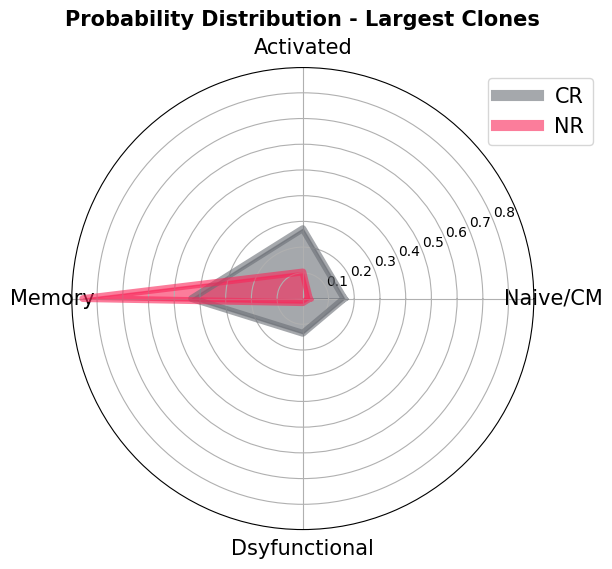

In [151]:
sub = adata[adata.obs["clone_size"] > 50]
sub = sub[sub.obs["complete_response"] != "Unknown"]
tcri.pl.polar_plot(sub, splitby="complete_response",statistic="probability", title="Probability Distribution - Largest Clones",save="/Users/ceglian/Data/tcri/zhang/figures/zhang_pdist_polar.pdf",color_dict=main_color_map)

View of AnnData object with n_obs × n_vars = 12934 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response', 'timepoint_relapse', 'cr', 'clone_size', 'UMAP1', 'UMAP2', 'log(Clone Size)', 'instant_response', 'timepoint_instant', 'genevector', 'Naive/CM Pseudo-probability', 'Activated Pseudo-probability', 'Memory Pseudo-probability', 'Dsyfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'probability_columns', 'genevector_colors', 'complete_response_colors', 'response_colors', 'treatment_colors', 'timepoint_relapse_colors', 'timepoint_colors', 'patient_colors', 'instant_response_colors', 'timepoint_instant_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'joint_distribution'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'
Activated        0.664210

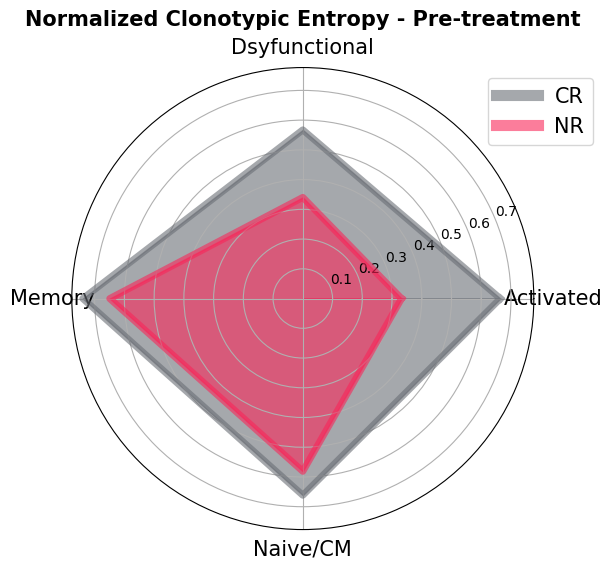

In [228]:
def polar_plot(adata, phenotypes=None, statistic="entropy", method="probabilistic", save=None, figsize=(6,6), title=None, alpha=0.6, fontsize=15, splitby=None, bbox_to_anchor=(1.15,1.), linewidth=5., legend_fontsize=15, color_dict=None):
    tcri.pp.joint_distribution(adata,method=method )
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')
    if splitby is None:
        splits = ['All']
    else:
        splits = list(set(adata.obs[splitby]))
    if phenotypes is None:
        phenotypes = adata.uns["joint_distribution"].index
    N = len(phenotypes)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    plot_theta = np.append(theta, theta[0])
    adata = adata[adata.obs[adata.uns["tcri_phenotype_key"]].isin(phenotypes)]
    for i, split in enumerate(splits): 
        if color_dict == None:
            colorx = tcri.pl.tcri_colors[i]
        else:
            colorx = color_dict[split]
        psubset = adata[adata.obs[splitby] == split]
        pdists = []
        for p in set(psubset.obs["patient"]):
            ppsubset = psubset[psubset.obs["patient"] == p]
            if len(ppsubset.obs.index) < 10: continue
            tcri.pp.joint_distribution(ppsubset)
            if statistic == "entropy":
                pdist = pd.Series(tcri.tl.clonotypic_entropies(ppsubset,normalized=True))
                phenotypes = pdist.index.tolist()
                pdists.append(pdist)
            else:    
                pdist = pdistribution(psubset, method=method)
            pdists.append(pdist)
        pdist = pd.DataFrame(pdists).T
        pdist = pdist.median(axis=1)
        print(pdist)
        pdist = pdist.tolist()
        pdist.append(pdist[0])
        ax.plot(plot_theta, pdist, color=colorx, alpha=alpha, label=split, linewidth=linewidth)
        ax.fill_between(plot_theta, 0, pdist, color=colorx, alpha=alpha)
    ax.set_xticks(theta)
    ax.set_xticklabels(phenotypes, fontsize=fontsize)
    ax.grid(True)
    leg = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    for line in leg.get_lines():
        line.set_linewidth(8.0)  # Set the line width
    if title:
        plt.title(title, va='bottom', fontsize=fontsize, fontweight="bold")
    if save:
        plt.savefig(save)
    
sub = adata[adata.obs["clone_size"] > 50]
print(sub)
sub = sub[sub.obs["complete_response"] != "Unknown"]
sub = sub[sub.obs["treatment"] != "Pre-treatment"]
sub = sub[sub.obs["genevector"] != "Naive/CM"]
tcri.pp.joint_distribution(sub)
polar_plot(sub, splitby="complete_response",statistic="entropy",title="Normalized Clonotypic Entropy - Pre-treatment",save="/Users/ceglian/Data/tcri/zhang/figures/zhang_entropy_polar_pre.pdf",color_dict=main_color_map)

View of AnnData object with n_obs × n_vars = 12934 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response', 'timepoint_relapse', 'cr', 'clone_size', 'UMAP1', 'UMAP2', 'log(Clone Size)', 'instant_response', 'timepoint_instant', 'genevector', 'Naive/CM Pseudo-probability', 'Activated Pseudo-probability', 'Memory Pseudo-probability', 'Dsyfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'probability_columns', 'genevector_colors', 'complete_response_colors', 'response_colors', 'treatment_colors', 'timepoint_relapse_colors', 'timepoint_colors', 'patient_colors', 'instant_response_colors', 'timepoint_instant_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'joint_distribution'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'
Activated        0.736660

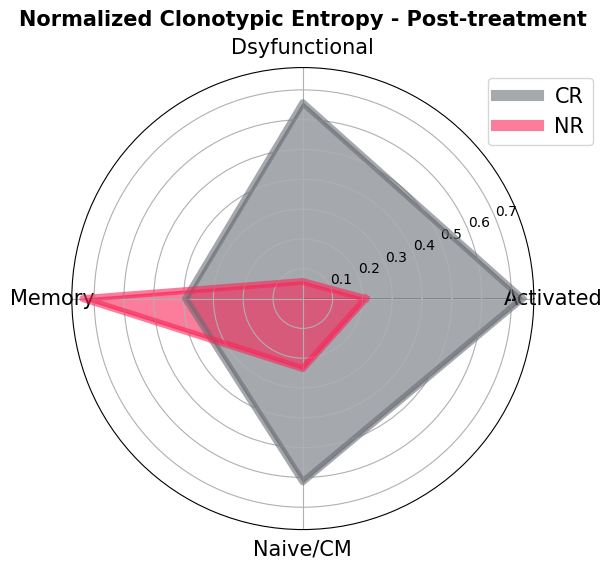

In [229]:
sub = adata[adata.obs["clone_size"] > 50]
print(sub)
sub = sub[sub.obs["complete_response"] != "Unknown"]
sub = sub[sub.obs["treatment"] != "Post-treatment"]
polar_plot(sub, splitby="complete_response",statistic="entropy",title="Normalized Clonotypic Entropy - Post-treatment",save="/Users/ceglian/Data/tcri/zhang/figures/zhang_entropy_polar_post.pdf",color_dict=main_color_map)

Activated        0.65798
Dsyfunctional    0.51085
Memory           0.05717
Naive/CM         0.56724
dtype: float64
Activated        0.317120
Dsyfunctional    0.266215
Memory           0.797590
Naive/CM         0.222955
dtype: float64
Activated        0.436745
Dsyfunctional    0.405850
Memory           0.353915
Naive/CM         0.643100
dtype: float64
Activated        0.31848
Dsyfunctional    0.27622
Memory           0.65390
Naive/CM         0.55724
dtype: float64


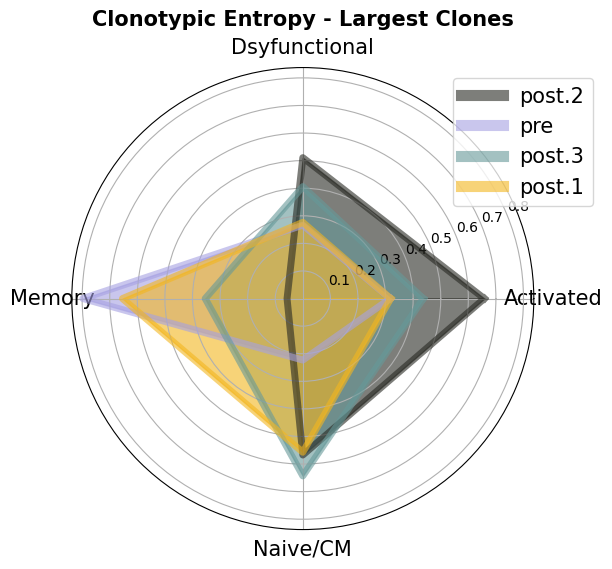

In [256]:
sub = adata[adata.obs["clone_size"] > 30]
sub = sub[sub.obs["complete_response"] == 'NR']
polar_plot(sub, splitby="timepoint",statistic="entropy", title="Clonotypic Entropy - Largest Clones",save="/Users/ceglian/Data/tcri/zhang/figures/zhang_pdist_polar_nr.pdf",color_dict=main_color_map)

Activated        0.636875
Dsyfunctional    0.648950
Memory           0.480605
Naive/CM         0.656165
dtype: float64
Activated        0.66586
Dsyfunctional    0.54997
Memory           0.65386
Naive/CM         0.72466
dtype: float64


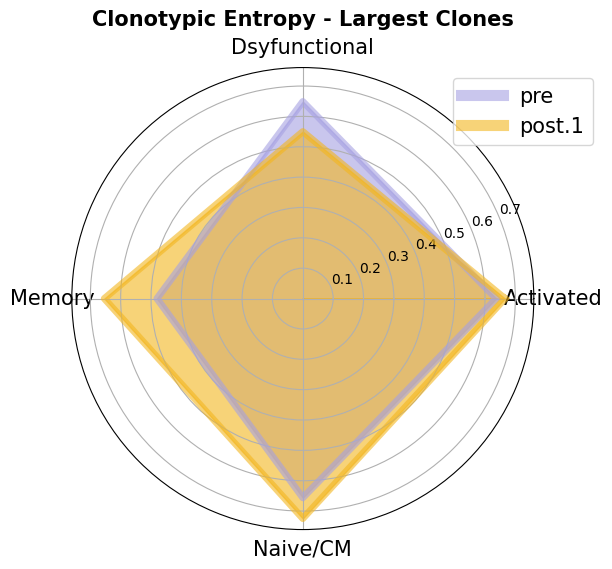

In [255]:
sub = adata[adata.obs["clone_size"] > 30]
sub = sub[sub.obs["complete_response"] == 'CR']
polar_plot(sub, splitby="timepoint",statistic="entropy", title="Clonotypic Entropy - Largest Clones",save="/Users/ceglian/Data/tcri/zhang/figures/zhang_pdist_polar_cr.pdf",color_dict=main_color_map)

[('Yes_post.1', 'No_post.1')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Yes_post.1 vs. No_post.1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-02 U_stat=2.400e+01


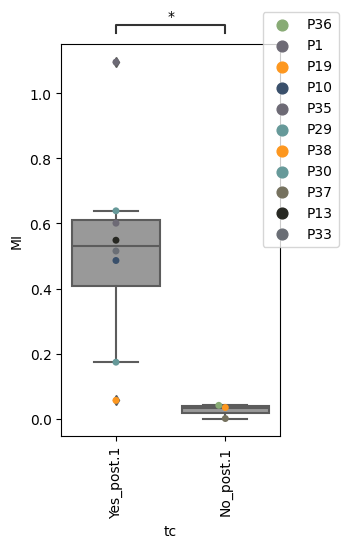

In [82]:
from tcri.pp import clone_size
from tcri.tl import mutual_information as mutual_information_tl
def mutual_information(adata, groupby, splitby=None, method="probabilistic", box_color="#999999", size=10, figsize=(6,5), colors=None, minimum_clone_size=1, rotation=90,return_df=False,bbox_to_anchor=(1.15, 1.15), order=None):
    mis = []
    groups = []
    splits = []
    for group in set(adata.obs[groupby]):
        gdata = adata[adata.obs[groupby] == group]
        clone_size(gdata)
        gdata = gdata[gdata.obs["clone_size"] >= minimum_clone_size]
        if splitby != None:
            for split in set(gdata.obs[splitby]):
                sdata = gdata[gdata.obs[splitby] == split]
                mi = mutual_information_tl(sdata, method=method)
                mis.append(mi)
                groups.append(group)
                splits.append(split)
        else:
            joint_distribution(gdata)
            mi = mutual_information_tl(gdata,method=method)
            mis.append(mi)
            groups.append(group)
    df = pd.DataFrame.from_dict({"MI":mis, groupby: groups})
    if splitby != None:
        df[splitby] = splits
    if order == None:
        order = list(set(adata.obs[splitby]))
    if colors == None:
        colors = tcri_colors
    fig, ax = plt.subplots(1,1,figsize=figsize)
    sns.boxplot(data=df,x=splitby,y="MI",ax=ax,order=order, color=box_color)
    sns.swarmplot(data=df,x=splitby,y="MI",order=order ,s=size, hue=groupby, palette=colors)
    pairs = list(itertools.combinations(set(df[splitby]),2))
    print(pairs)
    annotator = Annotator(ax, pairs=pairs, data=df, x=splitby, y="MI",order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
    fig.tight_layout()
    plt.xticks(rotation=rotation)
    _ = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor)
    if return_df:
        return df
    else:
        return ax

sub = adata[adata.obs["clone_size"] > 10]
sub = sub[sub.obs["tc"].isin(["Yes_post.1","No_post.1"])]
mutual_information(sub, groupby="patient",splitby="tc",figsize=(3,5), size=5, bbox_to_anchor=(1.3,1.1),colors=main_color_map)
plt.title("")
plt.savefig("/Users/ceglian/zhang_mutual_info.pdf")

In [106]:
import scirpy as ir
vdjdb = ir.datasets.vdjdb()
vdjdb_nobadref = vdjdb[vdjdb.obs['reference.id']!='https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#'].copy()
vdjdb_nobadref_human = vdjdb_nobadref[vdjdb_nobadref.obs['antigen.species'].isin(['HomoSapiens','Homo sapiens'])]
# ir.tl.ir_query(adata, vdjdb_nobadref_human, metric="identity", sequence="aa", receptor_arms="VDJ", dual_ir="primary_only")

In [453]:
ct = []
vall = []
tcri.pp.register_clonotype_key(xdata,"trbaa")
look = tcri.tl.phenotypic_entropies(xdata)
for x in xdata.obs["trbaa"]:
    val = look[x] 
    if val > 0.1:
        ct.append("High")
        vall.append(val)
    else:
        ct.append("Low")
        vall.append(val)
xdata.obs["pent"] = ct
xdata.obs["pentv"] = vall

['CASSQDLSGGVYYGYTF', 'CSTLLAGGGDEQYF', 'CASSPTGLGETQYF', 'CSAPPGPLAHTQYF', 'CASSFKGTGPNQPQHF', ..., 'CASTKGASPGDEQFF', 'CASSLGMGTEAFF', 'CASSDPGQGVQTYEQYF', 'CASSISRGRGYNEQFF', 'CASRMNTEAFF']
Length: 2224
Categories (2223, object): ['CAAGGGAYTGELFF', 'CAAGGVNQPQHF', 'CAASQNTEAFF', 'CAATSGEASGQPQHF', ..., 'CTCSADRGAETLYF', 'CTSSQRGGYNEQFF', 'CWSFAGSYYVF', 'VQGVPGPGVNEQFF']

In [214]:
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import tqdm
import scanpy as sc
import networkx as nx
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from scipy.spatial import distance
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
import numpy as np
import operator
import collections
import os   
import pandas as pd
import gc
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

markers = dict()
markers["Naive/CM"] = ["IL7R"]
markers["Activated"] = ["GZMB"]
markers["Memory"] = ["GZMK"]
markers["Dsyfunctional"] = ["CXCL13"]

def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from sklearn import preprocessing

def phenotype_probability(self, adata, phenotype_markers, return_distances=False, method="sparsemax", target_col="genevector", temperature=0.05, normalize=True):
    """
    Probablistically assign phenotypes based on a set of cell type labels and associated markers. 
    Can optionally return the original cosine distances and perform the assignment based on expression weight gene vectors.
    Loads into the anndata the pseudo-probabilities for each cell type and the deterministic label taken from the maximum probability over cell types.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param phenotype_markers: Dictionary of cell type labels (key) to gene markers used to define the cell type as a list (value).
    :type phenotype_markers: dict
    :param return_distances: Change the return type to a tuple that includes a dictionary containing the actual cosine distances alongside the phenotype probabilities.
    :type column: bool
    :param expression_weighted: Compute similarit to each cell using the expression weightedy marker gnene vector.
    :type column: bool
    :param target_col: Column label to load in deterministic cell asssignments in the obs data frame of the anndata object.
    :type target_col: bool
    :return: Anndata with cell type labels and probabilities, or optionally a tuple with the anndata and the raw cosine similarities.
    :rtype:  anndata.AnnData
    """
    if method == "softmax":
        print(bcolors.OKBLUE+"Using **SoftMax**"+bcolors.ENDC)
        pfunc = softmax
    elif method == "sparsemax":
        print(bcolors.OKBLUE+"Using **SparseMax**"+bcolors.ENDC)
        pfunc = self.entmax_15
    elif method == "normalized_exponential":
        print(bcolors.OKBLUE+"Using Normalized Exponential (Temp: {})".format(temperature)+bcolors.ENDC)
        pfunc = lambda x: self.normalized_exponential_vector(x, temperature)
    for x in adata.obs.columns:
        if "Pseudo-probability" in x:
            del adata.obs[x]
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    genes = adata.var.index.to_list()
    cells = adata.obs.index.to_list()
    all_markers = []
    for _, markers in phenotype_markers.items():
        all_markers += markers  
    all_markers = list(set(all_markers))
    probs = dict()

    for pheno, markers in phenotype_markers.items():
        print(bcolors.OKBLUE+"Computing similarities for {}".format(pheno)+bcolors.ENDC)
        print(bcolors.OKGREEN+"Markers: {}".format(", ".join(markers))+bcolors.ENDC)
        vector = self.embed.generate_vector(markers)
        probs[pheno] = cell_distance(self, vector,norm=normalize)
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = np.array(distribution)
    distribution = preprocessing.normalize(distribution)
    distribution = list(zip(*distribution))
    probabilities = []
    for d in distribution:
        p = pfunc(numpy.array(d))
        probabilities.append(p)
    
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    def load_predictions(adata,probs):
        prob_cols = []
        for ph in probs.keys():
            prob_cols.append(ph+" Pseudo-probability")
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        adata.uns["probability_columns"] = prob_cols
        return adata
    adata = load_predictions(adata, probs)
    if return_distances:
        return adata, res
    else:
        return adata

adata, dist = phenotype_probability(cembed, adata, markers, method="normalized_exponential", temperature=0.0004, return_distances=True, normalize=True)
tcri.pp.register_clonotype_key(adata,"trb")
#sub = adata[adata.obs["clone_size"] > 1]
sub = adata.copy()
tcri.pp.joint_distribution(sub)
mat = sub.uns["joint_distribution"] / sub.uns["joint_distribution"].sum(axis=0)
mat = mat.T

df = pd.DataFrame(mat)
print(df.shape)
# Initialize UMAP. n_neighbors and min_dist are important parameters to tune
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit the model to your data
embedding = reducer.fit_transform(mat)

mapper = dict(zip(sub.obs["trb"],sub.obs["tcs"]))
rows = []
for x in df.index:
    r = mapper[x]
    if "None" in r:
        rows.append("_None")
    else:
        rows.append(r)
dat = tcri.tl.phenotypic_entropies(adata)
ct = []
for x in df.index:
    ct.append(dat[x])
df["entropy"] = ct
df["tcs"] = rows


df["x"] =  embedding[:, 0]
df["y"] =  embedding[:, 1]

Using Normalized Exponential (Temp: 0.0004)
Computing similarities for Naive/CM
Markers: IL7R


100%|██████████| 77030/77030 [00:01<00:00, 72445.91it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 77030/77030 [00:01<00:00, 72363.85it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 77030/77030 [00:01<00:00, 65475.09it/s]


Computing similarities for Dsyfunctional
Markers: CXCL13


100%|██████████| 77030/77030 [00:01<00:00, 69571.27it/s]


(41540, 4)


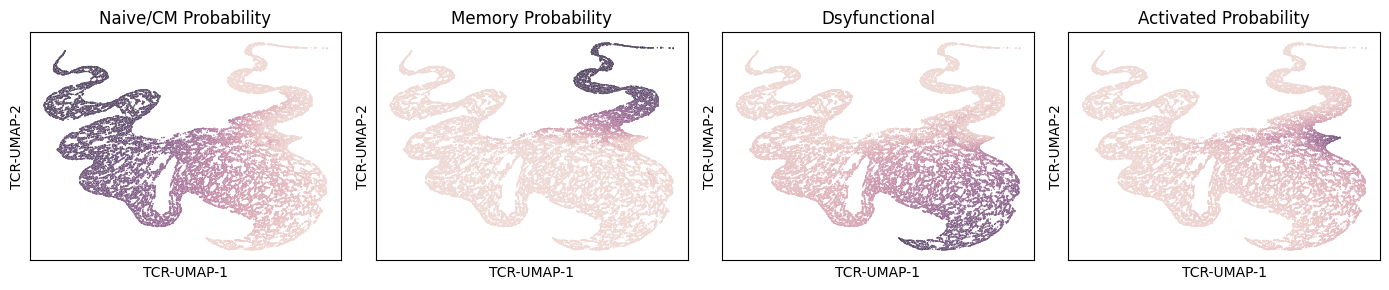

In [212]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots(1,4,figsize=(14, 3))
sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Naive/CM",ax=ax[0],legend=None,s=1)
ax[0].set_title("Naive/CM Probability")
sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Memory",ax=ax[1],legend=None,s=1)
ax[1].set_title("Memory Probability")
sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Dsyfunctional",ax=ax[2],legend=None,s=1)
ax[2].set_title("Dsyfunctional")
sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Activated",ax=ax[3],legend=None,s=1)
ax[3].set_title("Activated Probability")


for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel('TCR-UMAP-1')
    axis.set_ylabel('TCR-UMAP-2')

fig.tight_layout()
fig.savefig("/Users/ceglian/clonemap_zhang.pdf")